# Промышленность — задача проекта

**Дано:** чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали

**Задача:** Построить модель, которая предскажет температуру стали.

**Условия:**
- random_state = 141122
- объединение таблиц по ключам, которые есть во всех таблицах
- кросс-валидация, проверка качества лучшей модели на тесте
- train:test – 3:1
- гиперпараметры и встроенная CV или cross_val_score()

**План:**
1. Загрузка и обзор данных
2. EDA
#### Вопросы и примерный план решения задачи
3. Очистка данных. Заполнение данных
<br>Скорее всего, отрицательную мощность, температуру ниже 1500 надо удалить. Также надо удалить промежуточные температуры. Пропуски, где не подавали легирующие добавки, заполню нулями
4. Построение единой таблицы:
    - вычисление длительности времени между первым и последним замером температуры, стартовая и финальная температуры - в отдельные столбцы-признаки. Финальная температура станет целевым признаком
    - вычисление затрат энергии (мощность * время)
    - объединение таблиц по key, номеру партии
    - исследования о корреляции признаков и масштабировании признаков
5. Разделение на выборки 3:1
6. Обучение моделей с кросс-валидацией и выбор лучшей по показателю MAE. Использую линейную регрессию, случайный лес, градиентный бустинг и спуск, полиномиальную регрессию
7. Предсказание на тестовой выборке. Модель с наименьшим MAE проверю на тестовой выборке
8. Проверка модели на вменяемость через DummyRegressor
9. Анализ значимости признаков для предсказания
10. Общий вывод
11. Отчет

In [1]:
#константа
RANDOM_STATE = 141122

## 1. Загрузка данных

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import  make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from xgboost import XGBRegressor

In [4]:
try:
    #данные об электродах
    data_arc = pd.read_csv('/Users/galina/Desktop/учёба/спринт 16. Финал/final_steel/data_arc.csv',
                           parse_dates=[1, 2])
    
    #данные о подаче сыпучих материалов (объём)
    data_bulk = pd.read_csv('/Users/galina/Desktop/учёба/спринт 16. Финал/final_steel/data_bulk.csv')

    #данные о подаче сыпучих материалов (время)
    data_bulk_time = pd.read_csv('/Users/galina/Desktop/учёба/спринт 16. Финал/final_steel/data_bulk_time.csv',
                                 parse_dates=list(range(1, 16))) 

    #данные о продувке сплава газом
    data_gas = pd.read_csv('/Users/galina/Desktop/учёба/спринт 16. Финал/final_steel/data_gas.csv')

    #результаты измерения температуры
    data_temp = pd.read_csv('/Users/galina/Desktop/учёба/спринт 16. Финал/final_steel/data_temp.csv',
                           parse_dates=[1])

    #данные о проволочных материалах (объём)
    data_wire = pd.read_csv('/Users/galina/Desktop/учёба/спринт 16. Финал/final_steel/data_wire.csv')

    #данные о проволочных материалах (время)
    data_wire_time = pd.read_csv('/Users/galina/Desktop/учёба/спринт 16. Финал/final_steel/data_wire_time.csv',
                                parse_dates=list(range(1, 10)))

except:
    data_arc = pd.read_csv(path + '/data_arc.csv', parse_dates=[1, 2])
    data_bulk_time = pd.read_csv(path + '/data_bulk_time.csv', parse_dates=list(range(1, 16)))
    data_bulk = pd.read_csv(path + '/data_bulk.csv')
    data_gas = pd.read_csv(path + '/data_gas.csv')
    data_temp = pd.read_csv(path + '/data_temp.csv', parse_dates=[1])
    data_wire = pd.read_csv(path + '/data_wire.csv')
    data_wire_time = pd.read_csv(path + '/data_wire_time.csv', parse_dates=list(range(1, 10)))

## 2. Обзор данных

In [5]:
for _ in [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]:
    print('Первые 5 строк:')
    display(_.head())
    print()
    print('Последние 5 строк:')
    display(_.tail())
    print()
    print('Инфо по таблице:')
    display(_.info())
    print()
    print('Статистика по таблице:')
    display(_.describe(datetime_is_numeric=True))
    print()
    print('Кол-во дубликатов:', _.duplicated().sum())
    print()
    print('Распределение по партиям:')
    print(_.key.value_counts(normalize=True))
    print()
    print('------------------------------------------------------------------------------------------')
    print()

Первые 5 строк:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397



Последние 5 строк:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None


Статистика по таблице:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-02 16:15:28.218203904,2019-07-02 16:18:19.889150208,0.670441,0.452592
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.030002,-715.504924
25%,806.000000,2019-06-02 07:01:09.249999872,2019-06-02 07:04:21,0.395297,0.290991
50%,1617.000000,2019-06-30 09:57:14.500000,2019-06-30 10:01:01,0.555517,0.415962
75%,2429.000000,2019-08-03 13:04:47.750000128,2019-08-03 13:09:14,0.857034,0.637371
max,3241.000000,2019-09-01 04:34:47,2019-09-01 04:36:08,3.731596,2.676388
std,934.571502,NaN,NaN,0.408159,5.878702



Кол-во дубликатов: 0

Распределение по партиям:
2108    0.001076
1513    0.001008
1689    0.001008
2567    0.000941
46      0.000874
          ...   
112     0.000067
2472    0.000067
2025    0.000067
3059    0.000067
1615    0.000067
Name: key, Length: 3214, dtype: float64

------------------------------------------------------------------------------------------

Первые 5 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Последние 5 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None


Статистика по таблице:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Кол-во дубликатов: 0

Распределение по партиям:
1       0.00032
2174    0.00032
2152    0.00032
2153    0.00032
2154    0.00032
         ...   
1092    0.00032
1093    0.00032
1094    0.00032
1095    0.00032
3241    0.00032
Name: key, Length: 3129, dtype: float64

------------------------------------------------------------------------------------------

Первые 5 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56



Последние 5 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaT,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaT,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:39:41,NaT,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 04:05:34,2019-09-01 04:05:34



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None


Статистика по таблице:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-27 08:32:26.031746048,2019-07-09 02:04:44.545454336,2019-07-05 14:02:19.653312768,2019-06-30 17:27:38.687376896,2019-07-10 12:23:28.623376640,2019-07-03 15:57:30.003472384,2019-07-23 21:38:41.040000,2019-07-05 17:46:11,2019-06-21 00:53:43.157894912,2019-07-04 02:03:09.647727616,2019-07-11 23:35:46.310734336,2019-07-03 02:04:28.317142784,2019-06-29 02:00:06.722222336,2019-07-03 10:03:08.939059200,2019-07-03 16:07:21.480871936
min,1.000000,2019-05-03 17:50:19,2019-05-07 08:36:19,2019-05-03 20:13:36,2019-05-03 11:21:30,2019-05-07 08:36:19,2019-05-03 18:52:57,2019-05-07 11:37:42,2019-07-05 17:46:11,2019-05-14 00:04:56,2019-05-06 01:36:24,2019-05-05 16:45:05,2019-05-03 11:03:52,2019-05-05 00:39:35,2019-05-03 11:03:52,2019-05-03 11:03:52
25%,816.000000,2019-05-28 02:36:05.750000128,2019-05-26 21:24:43.249999872,2019-06-06 08:39:05.500000,2019-05-29 08:23:05.750000128,2019-06-17 19:42:11,2019-06-05 04:40:07,2019-07-17 11:25:12,2019-07-05 17:46:11,2019-05-14 02:37:23.500000,2019-05-31 15:29:27.500000,2019-06-12 19:24:37,2019-06-01 23:11:18,2019-05-27 22:41:40.750000128,2019-06-02 12:09:03.249999872,2019-06-02 18:47:20.249999872
50%,1622.000000,2019-06-23 02:31:45.500000,2019-07-23 15:06:49.500000,2019-07-01 17:13:22,2019-06-25 18:44:37.500000,2019-07-21 23:25:54,2019-07-06 03:56:28.500000,2019-07-23 15:37:44,2019-07-05 17:46:11,2019-05-14 05:15:06,2019-07-03 08:39:55.500000,2019-07-20 18:08:09,2019-06-30 09:36:04,2019-06-28 22:21:35,2019-07-01 05:46:54.500000,2019-07-01 00:46:14.500000
75%,2431.000000,2019-07-27 00:38:33.249999872,2019-08-08 10:55:53.750000128,2019-08-06 14:11:27.750000128,2019-07-30 21:37:44,2019-08-08 11:51:23,2019-08-03 09:02:40.750000128,2019-08-08 12:03:38,2019-07-05 17:46:11,2019-08-11 11:43:13,2019-07-30 19:28:59,2019-08-06 18:01:34,2019-08-04 04:41:33.249999872,2019-07-31 15:31:55.249999872,2019-08-04 17:37:32,2019-08-04 22:40:55
max,3241.000000,2019-08-30 23:01:32,2019-08-08 17:34:38,2019-08-31 23:39:11,2019-08-30 17:36:30,2019-08-28 09:01:08,2019-09-01 03:12:40,2019-08-31 07:22:25,2019-07-05 17:46:11,2019-08-11 15:09:33,2019-08-30 01:30:42,2019-08-31 16:00:49,2019-09-01 01:39:41,2019-08-26 20:31:16,2019-09-01 04:05:34,2019-09-01 04:05:34
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Кол-во дубликатов: 0

Распределение по партиям:
1       0.00032
2174    0.00032
2152    0.00032
2153    0.00032
2154    0.00032
         ...   
1092    0.00032
1093    0.00032
1094    0.00032
1095    0.00032
3241    0.00032
Name: key, Length: 3129, dtype: float64

------------------------------------------------------------------------------------------

Первые 5 строк:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Последние 5 строк:


,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None


Статистика по таблице:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Кол-во дубликатов: 0

Распределение по партиям:
1       0.000309
2166    0.000309
2156    0.000309
2157    0.000309
2158    0.000309
          ...   
1086    0.000309
1087    0.000309
1088    0.000309
1089    0.000309
3241    0.000309
Name: key, Length: 3239, dtype: float64

------------------------------------------------------------------------------------------

Первые 5 строк:


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0



Последние 5 строк:


,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


None


Статистика по таблице:


,key,Время замера,Температура
count,15907.000000,15907,13006.000000
mean,1607.880870,2019-07-02 09:55:01.000942848,1591.840920
min,1.000000,2019-05-03 11:16:18,1191.000000
25%,790.000000,2019-06-01 16:24:51.500000,1581.000000
50%,1618.000000,2019-06-30 10:31:14,1591.000000
75%,2427.000000,2019-08-03 12:07:59,1601.000000
max,3241.000000,2019-09-01 04:38:08,1705.000000
std,942.212073,NaN,21.375851



Кол-во дубликатов: 0

Распределение по партиям:
46      0.001006
1214    0.001006
44      0.001006
1513    0.001006
2108    0.000943
          ...   
1160    0.000126
982     0.000126
2456    0.000126
195     0.000063
279     0.000063
Name: key, Length: 3216, dtype: float64

------------------------------------------------------------------------------------------

Первые 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Последние 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None


Статистика по таблице:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Кол-во дубликатов: 0

Распределение по партиям:
1       0.000325
2226    0.000325
2146    0.000325
2147    0.000325
2148    0.000325
          ...   
1090    0.000325
1091    0.000325
1092    0.000325
1093    0.000325
3241    0.000325
Name: key, Length: 3081, dtype: float64

------------------------------------------------------------------------------------------

Первые 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT



Последние 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-08-31 22:50:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-08-31 23:38:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-01 01:50:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-01 03:12:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3080,3241,2019-09-01 04:16:01,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None


Статистика по таблице:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-03 02:48:18.296235776,2019-07-04 03:36:02.886005504,2019-07-07 13:45:31.634920704,2019-07-08 10:06:53.999999744,2019-08-08 16:01:07,2019-07-04 11:29:18.273972480,2019-08-02 18:36:35.818181632,2019-06-21 00:52:37.894736896,2019-06-28 18:07:46.931034624
min,1.000000,2019-05-03 11:11:41,2019-05-03 13:32:06,2019-05-04 04:47:53,2019-05-07 08:48:23,2019-08-08 16:01:07,2019-05-07 08:37:20,2019-07-23 12:08:44,2019-05-14 00:03:32,2019-05-04 16:09:11
25%,823.000000,2019-06-03 02:59:53.500000,2019-06-03 21:52:38,2019-06-09 14:51:42.500000,2019-07-17 08:17:59,2019-08-08 16:01:07,2019-05-08 13:11:38,2019-07-23 19:31:31,2019-05-14 02:36:03.500000,2019-06-07 20:28:19
50%,1619.000000,2019-06-30 14:38:56,2019-07-02 06:40:13,2019-07-17 21:35:47,2019-07-23 10:44:22.500000,2019-08-08 16:01:07,2019-07-24 03:28:47,2019-08-08 10:43:30,2019-05-14 05:14:25,2019-06-09 10:26:00
75%,2434.000000,2019-08-03 22:58:26,2019-08-04 13:10:39.500000,2019-08-08 10:03:45,2019-07-23 15:27:14.750000128,2019-08-08 16:01:07,2019-08-08 20:28:45,2019-08-08 12:43:10.500000,2019-08-11 11:43:21.500000,2019-08-04 20:48:59
max,3241.000000,2019-09-01 04:16:01,2019-08-31 18:50:15,2019-08-28 02:11:18,2019-08-08 12:03:12,2019-08-08 16:01:07,2019-08-14 00:59:11,2019-08-08 18:27:34,2019-08-11 15:09:29,2019-08-29 03:51:31
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Кол-во дубликатов: 0

Распределение по партиям:
1       0.000325
2226    0.000325
2146    0.000325
2147    0.000325
2148    0.000325
          ...   
1090    0.000325
1091    0.000325
1092    0.000325
1093    0.000325
3241    0.000325
Name: key, Length: 3081, dtype: float64

------------------------------------------------------------------------------------------



In [6]:
#проверяю, совпадают ли пропуски в `data_bulk` и `data_bulk_time` и `data_wire` и `data_wire_time
print((data_bulk_time.isna() == data_bulk.isna()).sum()) 
print()
print((data_wire.isna() == data_wire_time.isna()).sum())

key        3129
Bulk 1     3129
Bulk 2     3129
Bulk 3     3129
Bulk 4     3129
Bulk 5     3129
Bulk 6     3129
Bulk 7     3129
Bulk 8     3129
Bulk 9     3129
Bulk 10    3129
Bulk 11    3129
Bulk 12    3129
Bulk 13    3129
Bulk 14    3129
Bulk 15    3129
dtype: int64

key       3081
Wire 1    3081
Wire 2    3081
Wire 3    3081
Wire 4    3081
Wire 5    3081
Wire 6    3081
Wire 7    3081
Wire 8    3081
Wire 9    3081
dtype: int64


Промежуточные выводы:

- В датафрейме `data_arc` 14876 строк, пропусков, дубликатов нет. Есть выброс в признаке `Реактивная мощность` -715.504924 (реактивная мощность может быть отрицательной, когда устройство производит эту мощность, но это не тот случай). Распределение кол-ва нагревов по партиям неравномерное - больше всего нагревов у партии 2108

- В датафреймах `data_bulk` и `data_bulk_time` 16 признаков, из них во всех признаках Bulk есть пропуски, причем пропуски в датафреймах совпадает и, видимо, это просто отсутствие засыпки на определенном этапе. В датафреймах по 3129 строк, дубликатов нет.

- В датафрейме `data_gas` 3239 строк, 1 признак, пропусков и дубликатов нет, тип данных валидный. 

- В датафрейме `data_temp` 15907 строк, есть 2901 пропуск в признаке `Температура`. Дубликатов нет. Распределение измерения температур по партиям неравномерное - больше всего температура измерялась в партиях 46, 1214 и 44 

- В датафреймах `data_wire` и `data_wire_time` 3081 строка, 10 признаков, при этом во всех признаках `wire` есть пропуски, которые совпадают с пропусками в таблице `data_wire_time`. Как и в случае с сыпучими материалами, предполагаю, что пропуски - просто неподача проволоки. Дубликатов данных нет.

- Кол-во уникальных `key`, номеров партии, в таблицах разное:
  - 3241 в `data_arc`
  - 3129 в `data_bulk` и `data_bulk_time`
  - 3239 в `data_gas`
  - 3081 в `data_wire` и `data_wire_time`
<br>то есть при объединении таблиц по `key` часть данных будет пустая

- Сразу перевела в тип данных data данные в признаках `Начало нагрева дугой`, `Конец нагрева дугой`, `Wire`, `Время замера` - в таблицах данные с 03 мая по 01 сентября 2019 года

- Для единообразия можно все названия признаков перевести на русский, избавиться от верблюжьего стиля, пробелов. Но необязательно, возможно заказчику так удобнее

## 2. EDA

### 2.1. Данные об электродах (data_arc)

Text(0.5, 1.0, 'Гистограмма распределения времени начала нагрева дугой')

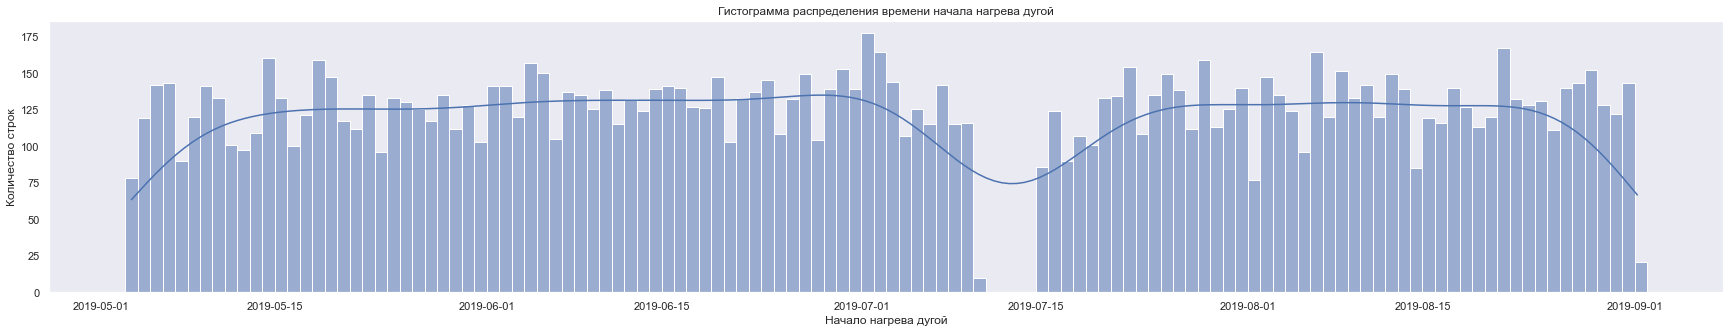

In [7]:
#строю гистограмму для признака 'Начало нагрева дугой' 
sns.set(rc={"figure.figsize": (30, 5)})
sns.set_style("dark")
ahs = sns.histplot(data=data_arc, x='Начало нагрева дугой', kde=True, discrete=True)
ahs.set_ylabel('Количество строк')
ahs.set_title('Гистограмма распределения времени начала нагрева дугой')

In [8]:
#смотрю, что за пропуск в седьмом месяце:
data_arc['Начало нагрева дугой'].dt.day[data_arc['Начало нагрева дугой'].dt.month==7].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

Резкий спад 10 июля и нет данных за 11-13 июля, возможно, из-за аварии. Либо из-за сбоя сборки данных

Text(0.5, 1.0, 'Гистограмма распределения времени конца нагрева дугой')

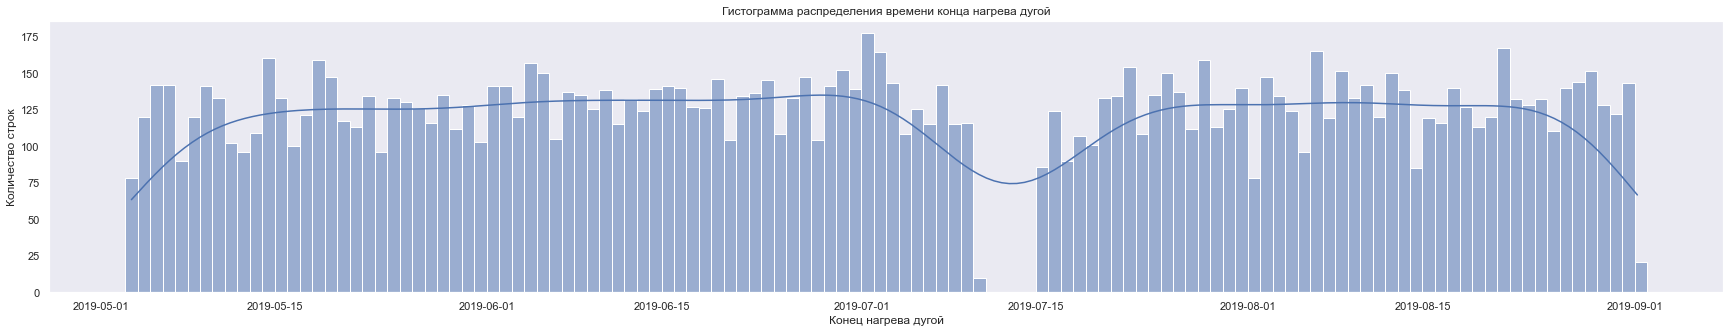

In [9]:
#строю гистограмму для признака 'Конец нагрева дугой' 
sns.set(rc={"figure.figsize": (30, 5)})
sns.set_style("dark")
ahf = sns.histplot(data=data_arc, x='Конец нагрева дугой', kde=True, discrete=True)
ahf.set_ylabel('Количество строк')
ahf.set_title('Гистограмма распределения времени конца нагрева дугой')

In [10]:
#смотрю, что за пропуск в седьмом месяце:
data_arc['Конец нагрева дугой'].dt.day[data_arc['Конец нагрева дугой'].dt.month==7].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

Точно такой же, как и в признаке 'Начало нагрева дугой', резкий спад 10 июля и нет данных за 11-13 июля

Text(0.5, 0, 'Активная мощность')

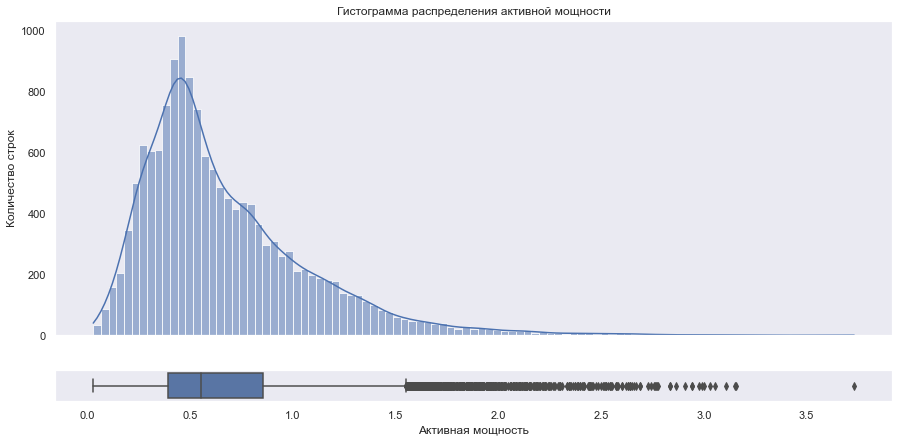

In [11]:
#строю гистограмму и боксплот для признака 'Активная мощность' 
_, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[10,1]))

ap_hist = sns.histplot(data=data_arc, x='Активная мощность', kde=True, ax=axs_hist)
ap_hist.set_ylabel('Количество строк')
ap_hist.set_title('Гистограмма распределения активной мощности')

ap_box = sns.boxplot(data=data_arc, x='Активная мощность', ax=axs_box) 
ap_box.set_xlabel('Активная мощность')

Распределение активной мощности похоже на нормальное и Пуассона со смещением влево. Среднее — 0.67, стандартное отклонение — 0.41

In [12]:
#смотрю строки, в которой `Реактивная мощность` меньше нуля
data_arc[data_arc['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [13]:
#поскольку отрицательной мощности не бывает в нашем случае, строка всего одна, удалю её:
data_arc = data_arc.drop(data_arc[data_arc['Реактивная мощность'] <= 0].index).reset_index(drop=True)

Text(0.5, 0, 'Реактивная мощность')

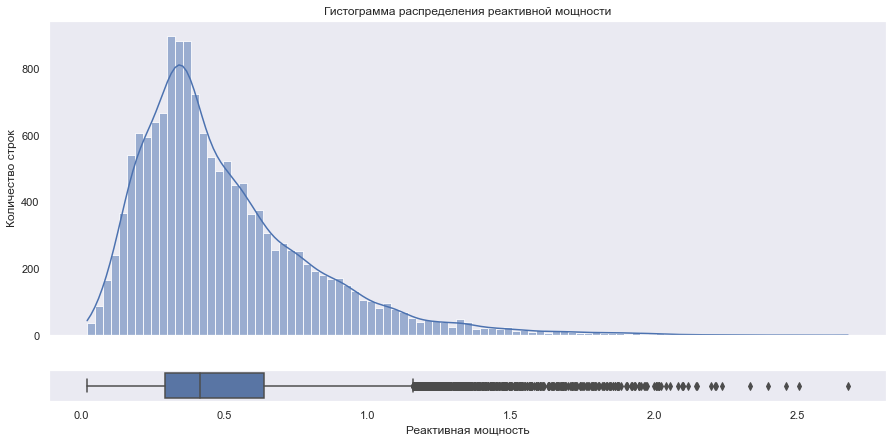

In [14]:
#строю гистограмму и боксплот для признака 'Реактивная мощность' 
_, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[10,1]))

ap_hist = sns.histplot(data=data_arc, x='Реактивная мощность', kde=True, ax=axs_hist)
ap_hist.set_ylabel('Количество строк')
ap_hist.set_title('Гистограмма распределения реактивной мощности')

ap_box = sns.boxplot(data=data_arc, x='Реактивная мощность', ax=axs_box) 
ap_box.set_xlabel('Реактивная мощность')

С учетом избавления от выброса распределение реактивной мощности также похоже на нормальное и Пуассона со смещением влево и хвостом справа. Среднее — 0.5, стандартное отклонение — 0.31

### 2.2. Данные о подаче сыпучих материалов / объём (data_bulk)

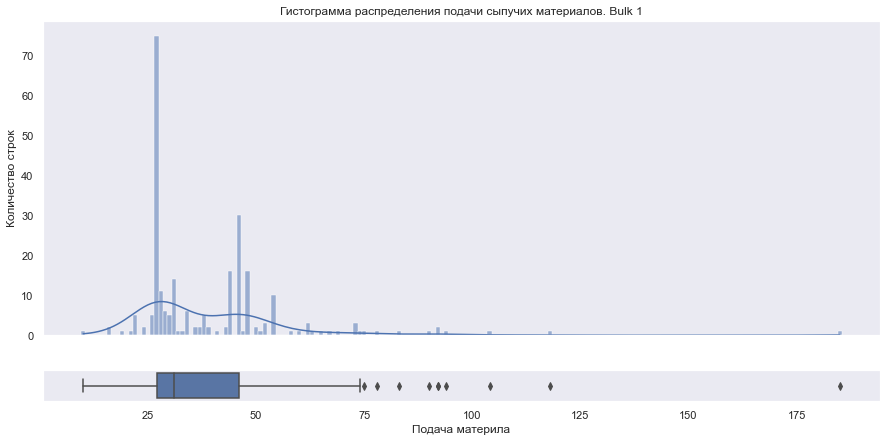

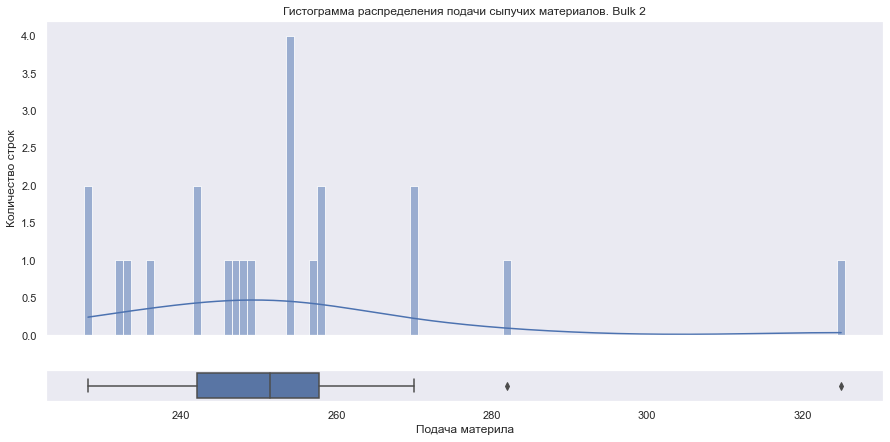

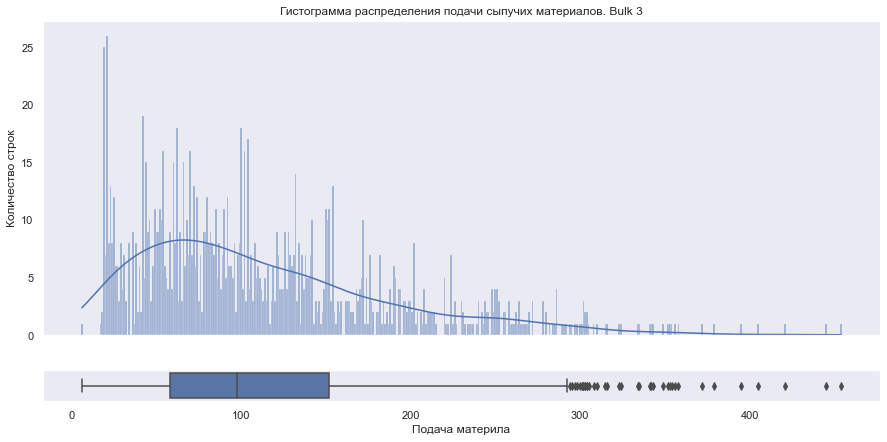

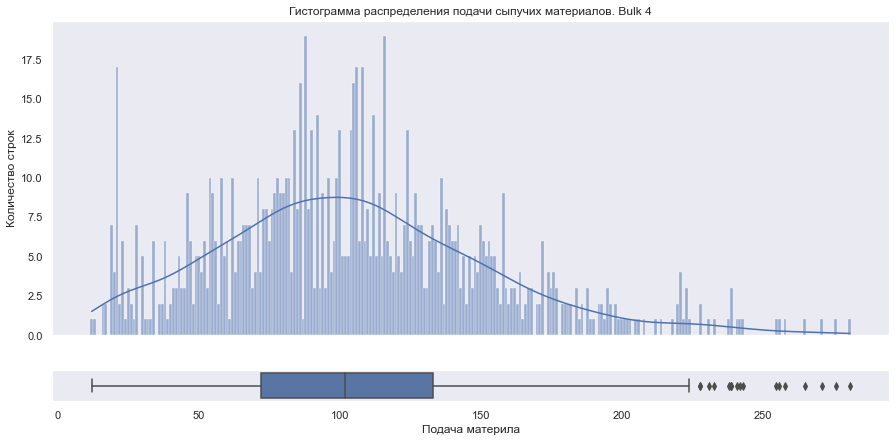

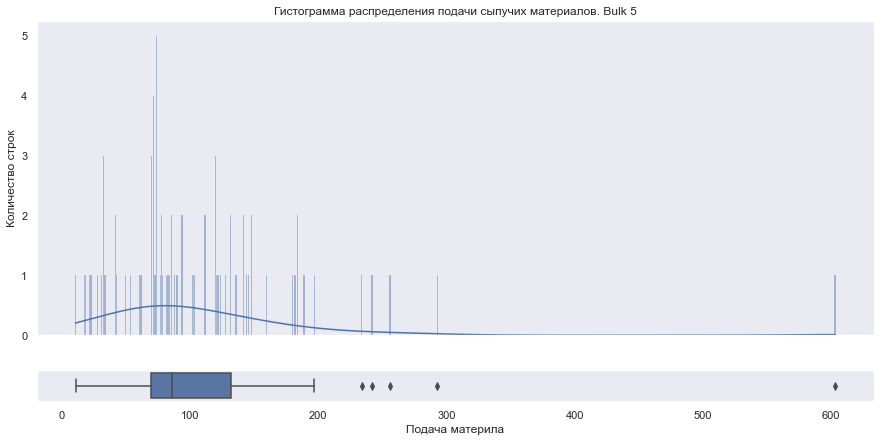

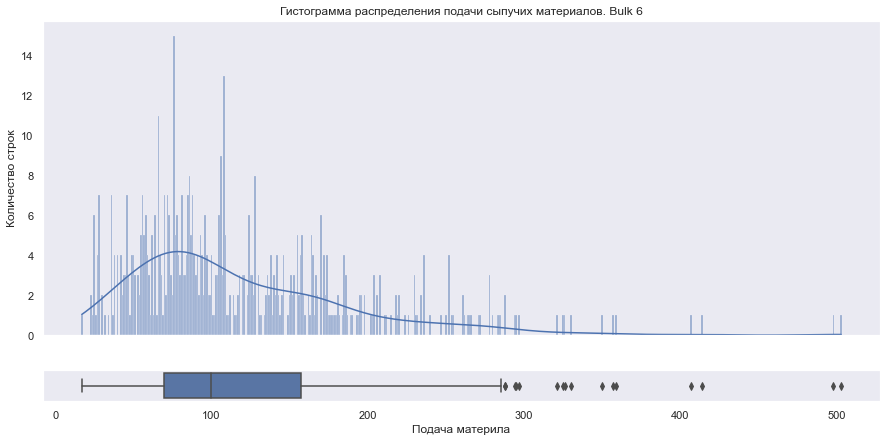

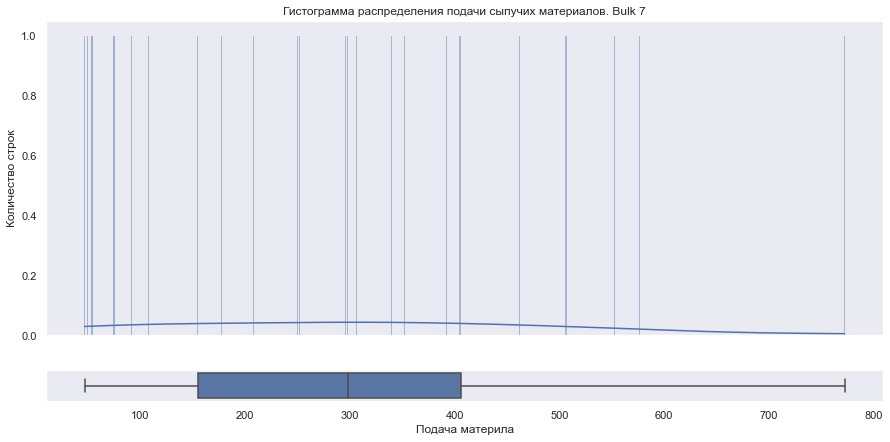

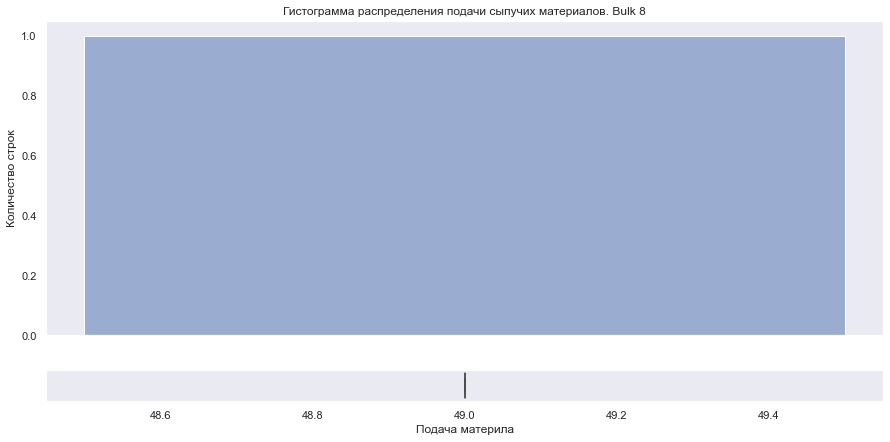

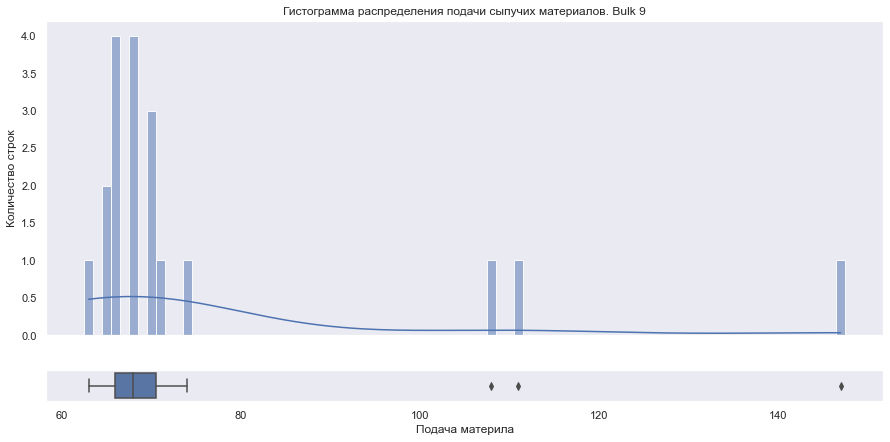

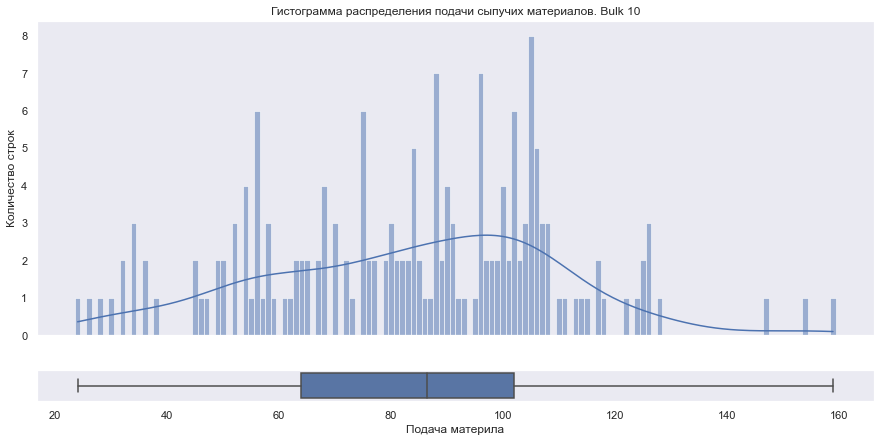

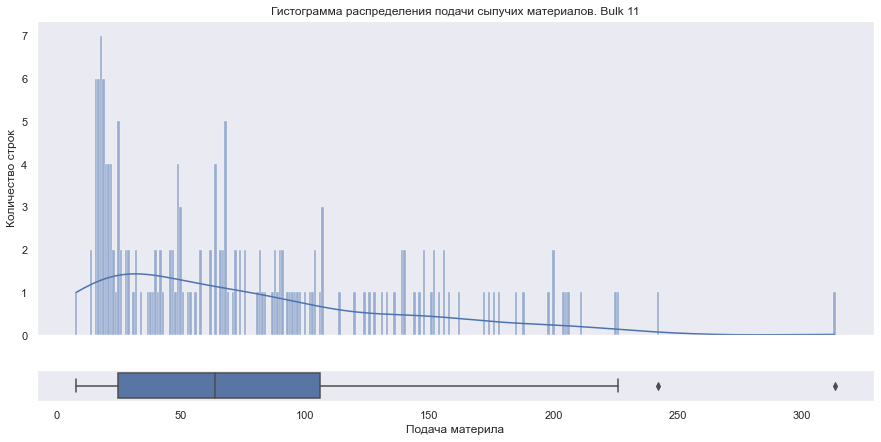

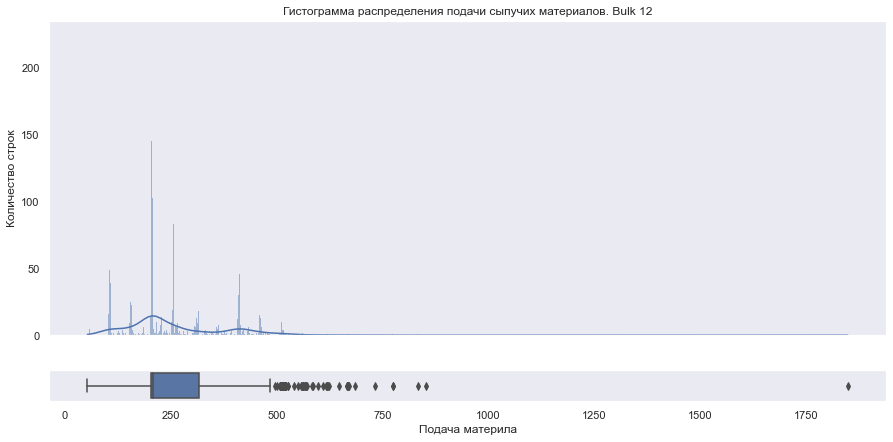

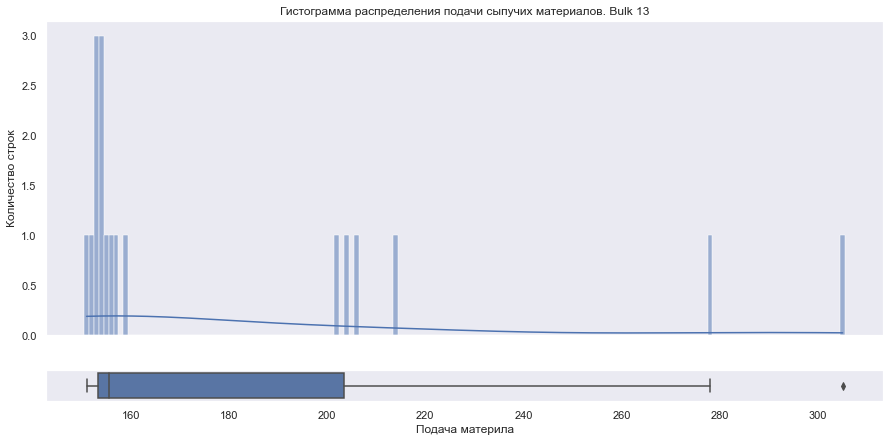

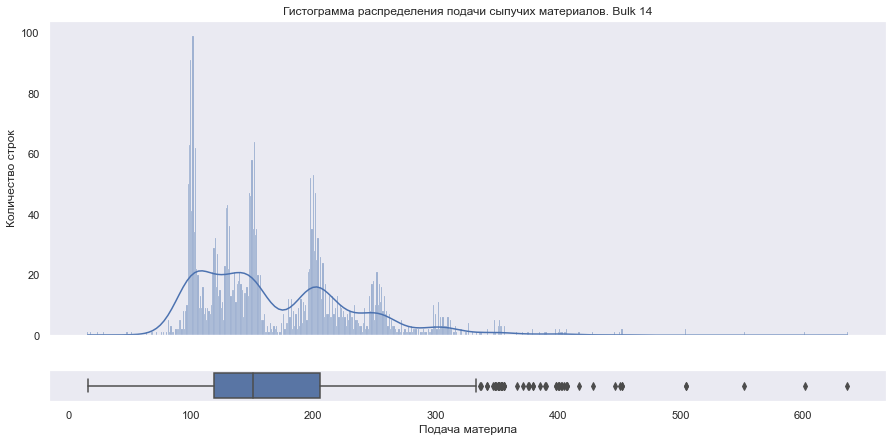

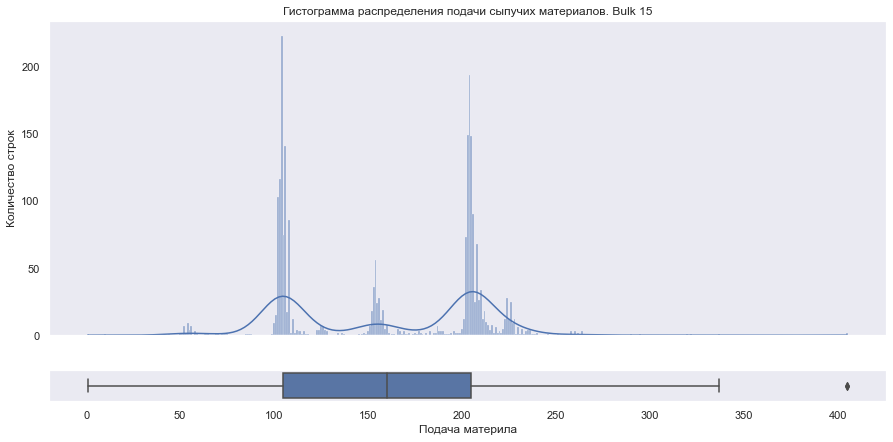

In [15]:
#строю гистограммы и боксплоты для каждого признака Bulk

bulks = data_bulk.columns.to_list()[1:]

for bulk in bulks:
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7), 
                                          sharex=True,
                                          gridspec_kw=dict(height_ratios=[10,1]))
    
    bulk_hist = sns.histplot(data=data_bulk, x=bulk, kde=True, ax=axs_hist, discrete=True)
    bulk_hist.set_ylabel('Количество строк')
    bulk_hist.set_title('Гистограмма распределения подачи сыпучих материалов. ' + bulk)
    
    bulk_box = sns.boxplot(data=data_bulk, x=bulk, ax=axs_box)
    bulk_box.set_xlabel('Подача материла')

In [16]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


По гистограммам видно, что сыпучие материалы добавляются в разных объемах, например, меньше всего в среднем добавляют `Bulk 1`, больше всего в среднем - `Bulk 7`. А чаще всего добавляют `Bulk 14`, и только 1 раз добавили `Bulk 8`. Почти на каждой гистограмме можно увидеть, что за 1 раз добавляется определенный объем легирующих добавок, так как столбцы гистограмм одинакового размера, особенно хорошо это заметно на `Bulk 10` и `Bulk 11`.

То есть разные сыпучие материалы (легирующие добавки) по-разному действуют на металл, а `Bulk 14` либо крайне редко использующаяся легирующая добавка, либо крайне дорогая, либо и то, и то.

### 2.3. Данные о подаче сыпучих материалов / время (data_bulk_time)

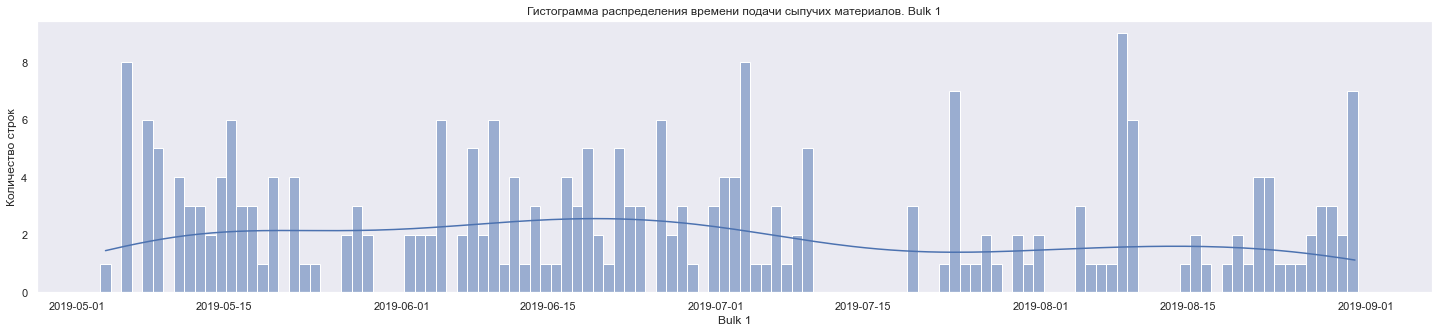

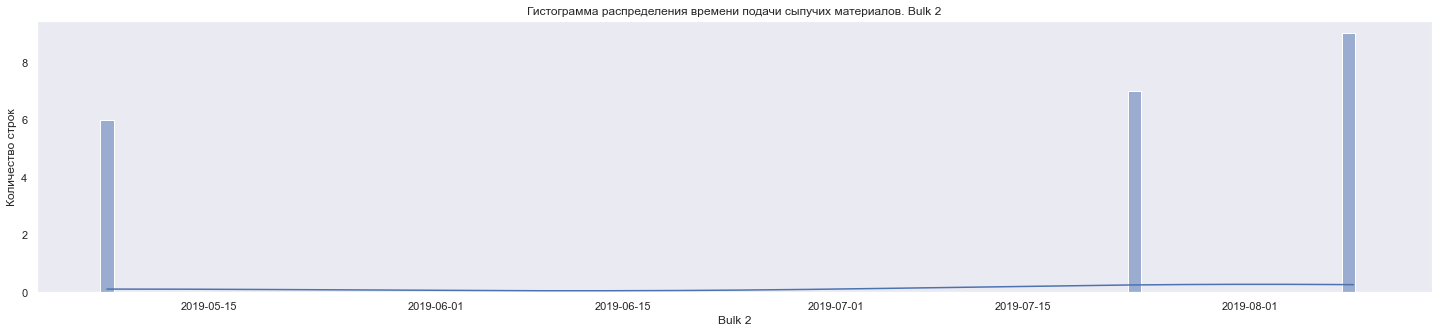

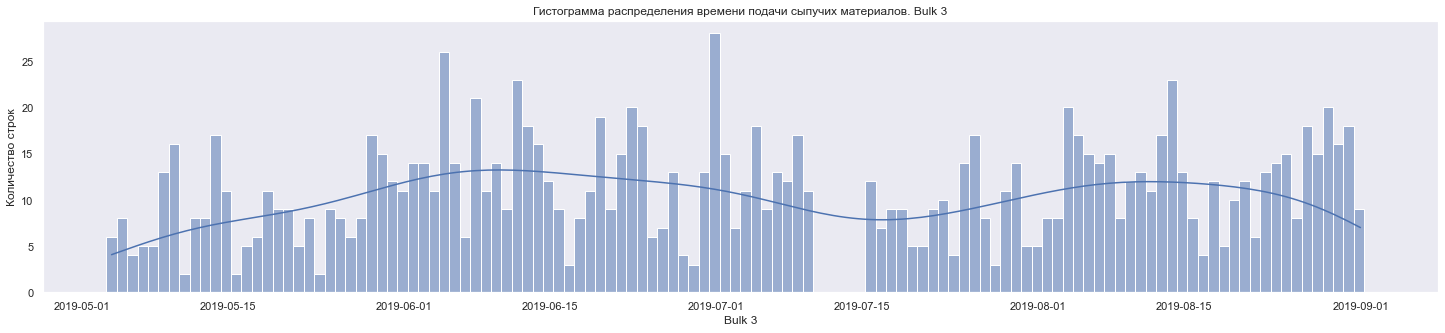

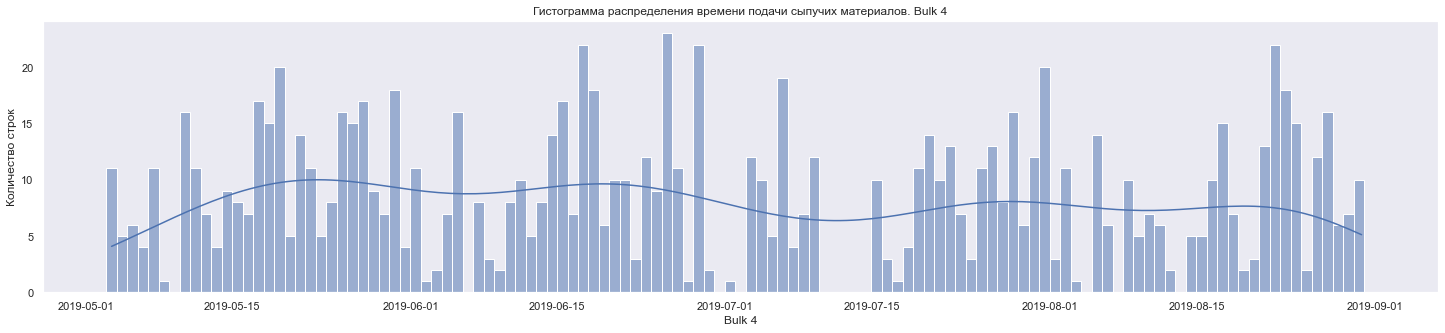

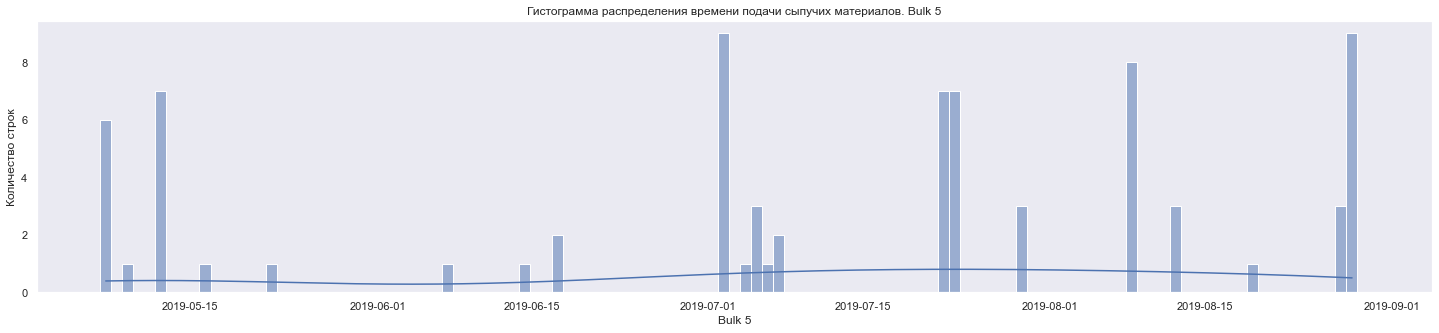

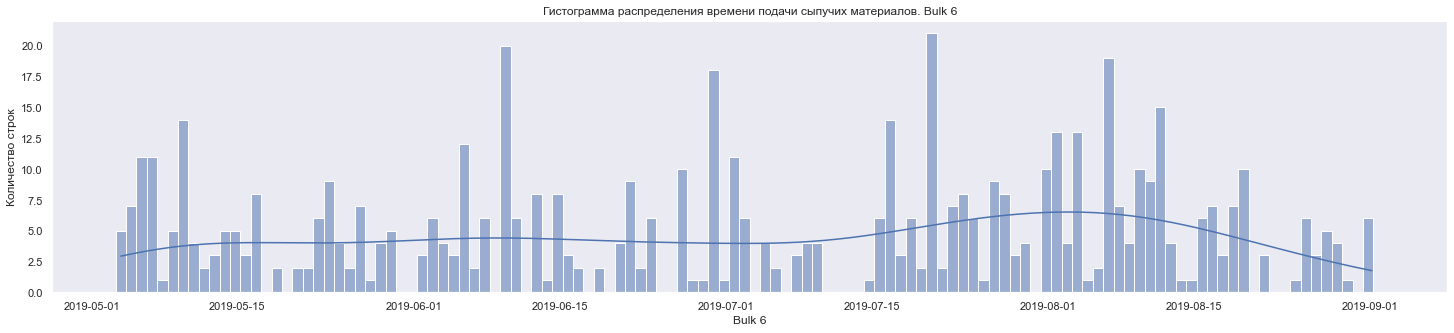

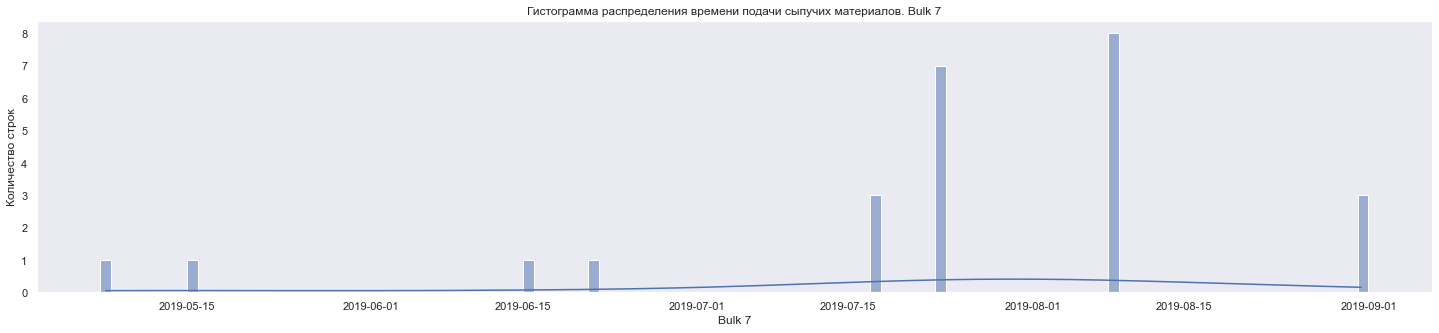

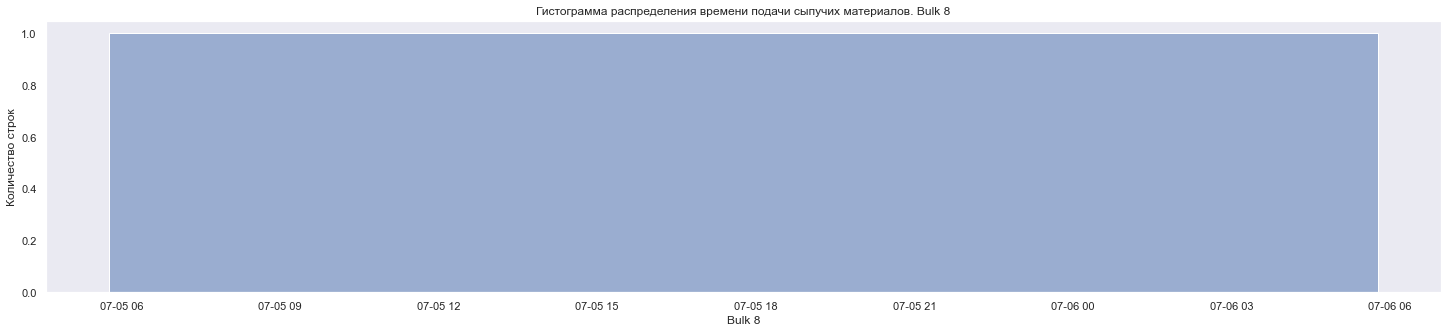

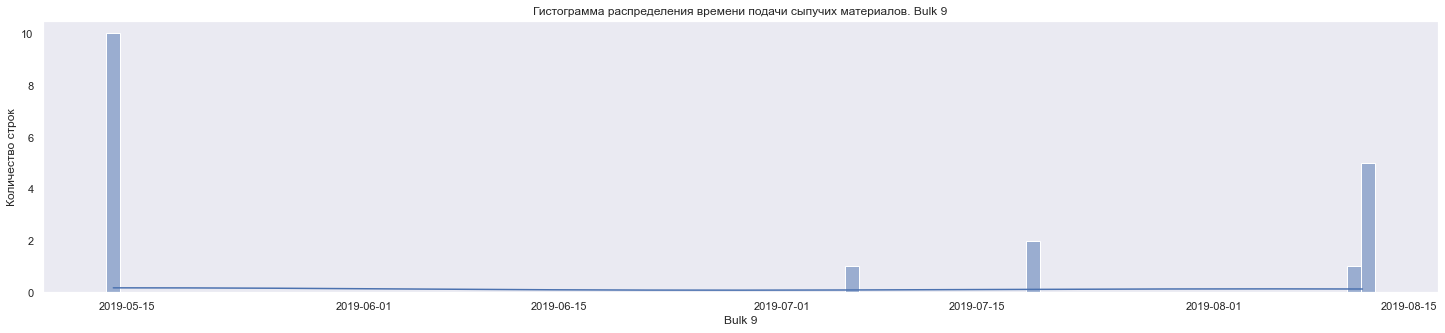

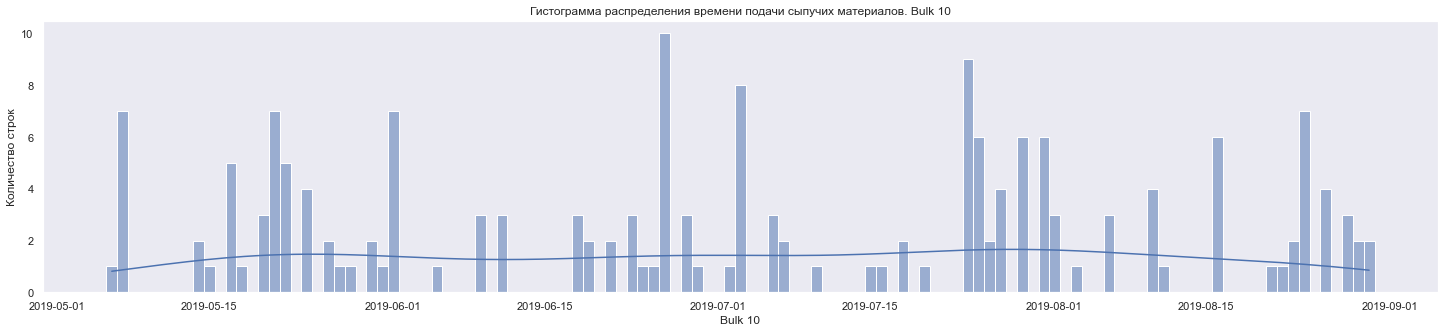

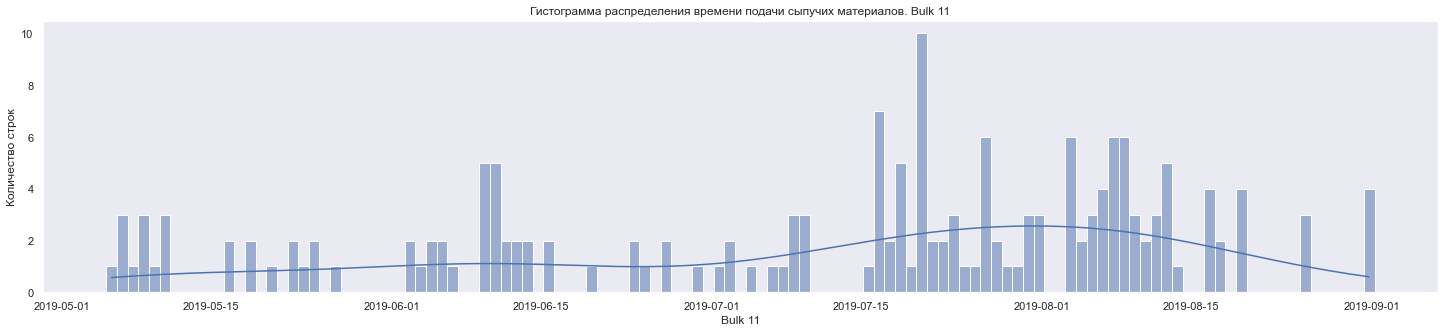

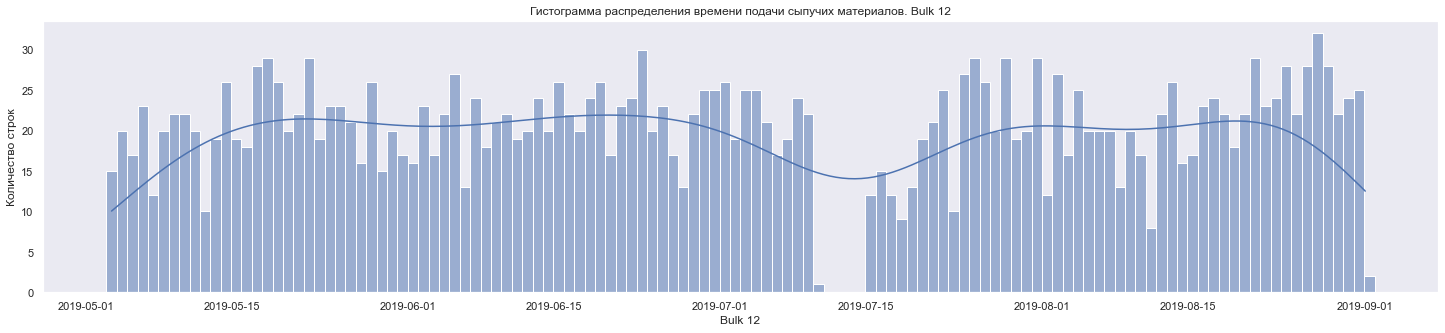

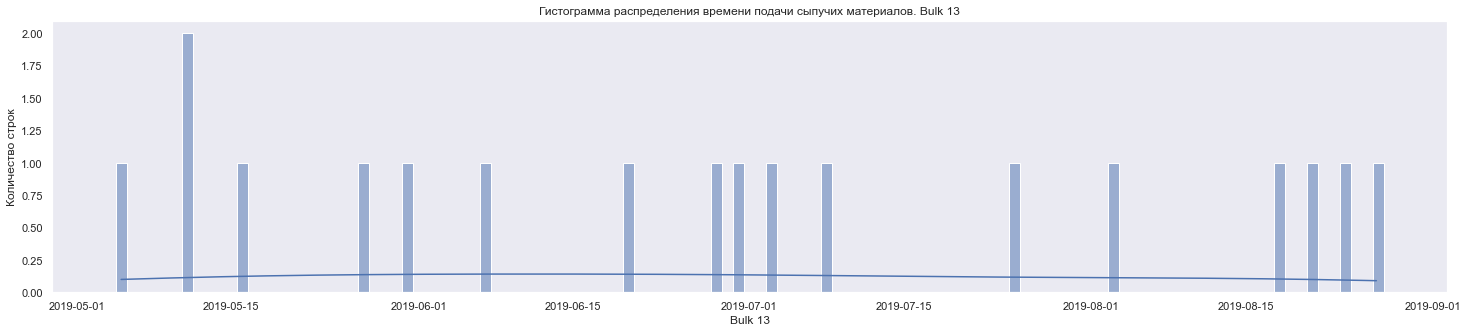

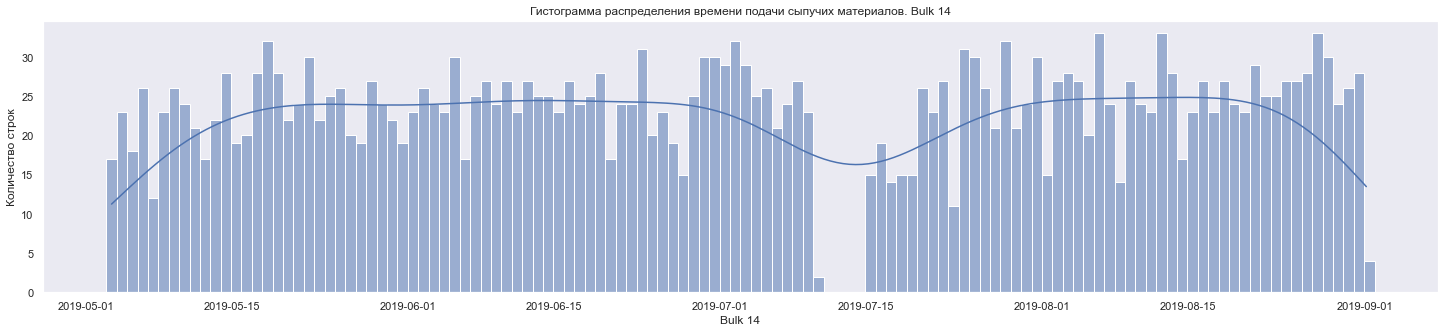

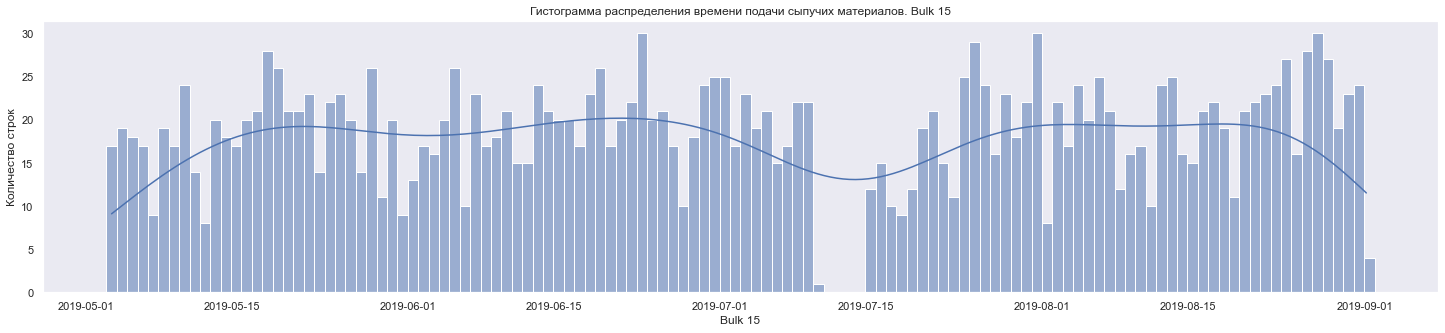

In [17]:
#названия признаков 'data_bulk_time' и 'data_bulk' одинаковые, поэтому использую bulks:
for bulk in bulks:
    sns.set(rc={"figure.figsize": (25, 5)})
    sns.set_style("dark")
    bulk_hist = sns.histplot(data=data_bulk_time, x=bulk, kde=True, discrete=True)
    bulk_hist.set_ylabel('Количество строк')
    bulk_hist.set_title('Гистограмма распределения времени подачи сыпучих материалов. ' + bulk)
    plt.show()

По гистограммам видно, что есть пропуск 11-13 июля, аналогичный пропуску в data_arc, что логично.
Кроме того, нет закономерности типа "в среду варим такой-то тип стали, добавляем такие-то добавки", то есть что есть в производственном плане (случайный выбор типа стали), то и варят.

И в соответствие с датафреймом `data_bulk`, на гистограммах видно, что разные сыпучие легирующие добавки добавляют с разной частотой - чаще всего добавляют `Bulk 14`, `Bulk 12`и `Bulk 15`.

### 2.4. Данные о продувке сплава газом (data_gas)

Text(0.5, 0, 'Газ')

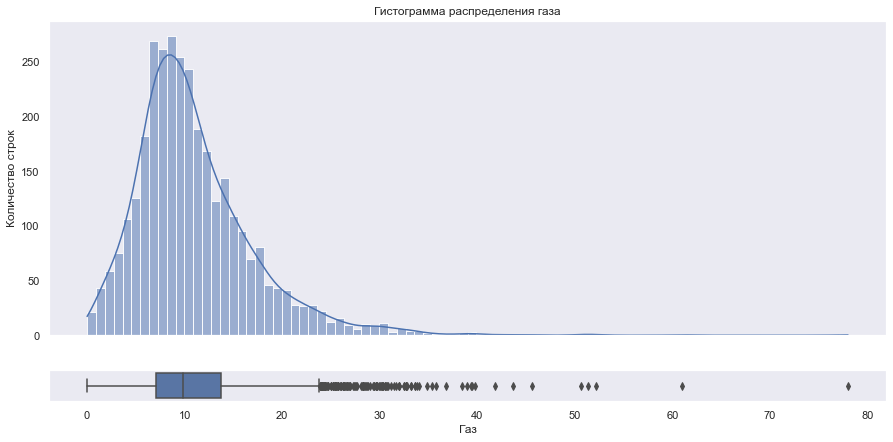

In [18]:
#строю гистограмму и боксплот для признака 'Газ 1' 
_, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[10,1]))

gas_hist = sns.histplot(data=data_gas, x='Газ 1', kde=True, ax=axs_hist)
gas_hist.set_ylabel('Количество строк')
gas_hist.set_title('Гистограмма распределения газа')

gas_box = sns.boxplot(data=data_gas, x='Газ 1', ax=axs_box) 
gas_box.set_xlabel('Газ')

Распределение газа также похоже на нормальное и Пуассона со смещением влево и хвостом справа. Среднее — 11, стандартное отклонение — 6.22, чаще всего продувают сплав 10±0.2 кубометрами газа

### 2.5. Результаты измерения температуры (data_temp)

Text(0.5, 1.0, 'Гистограмма распределения времени замера')

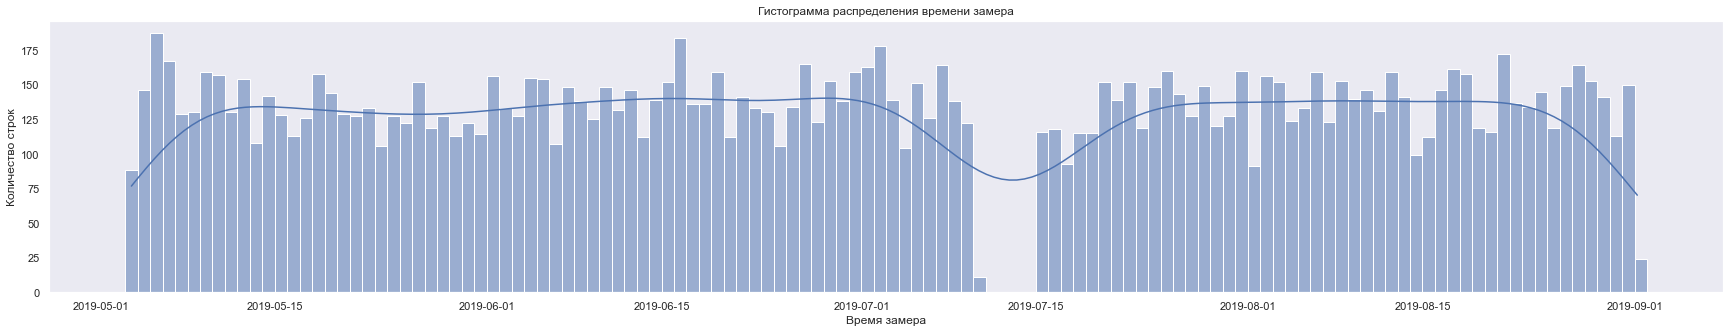

In [19]:
#строю гистограмму для признака 'Время замера' 
sns.set(rc={"figure.figsize": (30, 5)})
sns.set_style("dark")
ahf = sns.histplot(data=data_temp, x='Время замера', kde=True, discrete=True)
ahf.set_ylabel('Количество строк')
ahf.set_title('Гистограмма распределения времени замера')

Ожидаемо есть перерыв в работе 11-13 июля, как и в других гистограммах времени 

Text(0.5, 0, 'Температура')

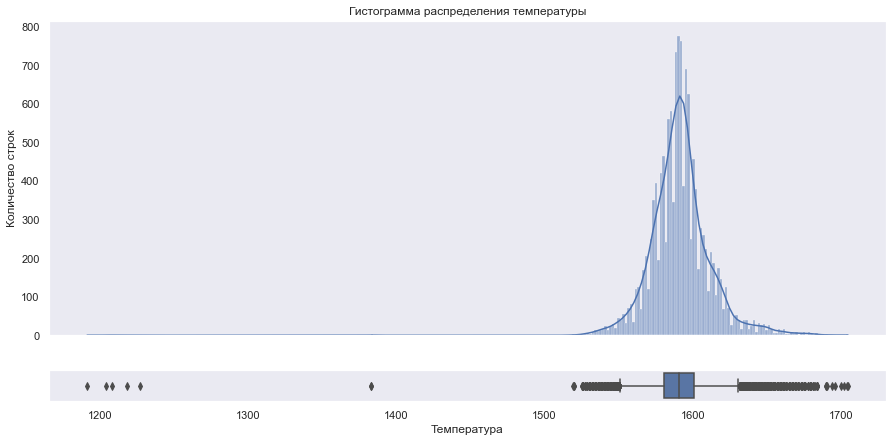

In [20]:
#строю гистограмму и боксплот для признака 'Температура' 
_, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[10,1]))

temp_hist = sns.histplot(data=data_temp, x='Температура', kde=True, ax=axs_hist)
temp_hist.set_ylabel('Количество строк')
temp_hist.set_title('Гистограмма распределения температуры')

temp_box = sns.boxplot(data=data_temp, x='Температура', ax=axs_box) 
temp_box.set_xlabel('Температура')

Распределение похоже на нормальное. Есть выбросы - температура ниже 1500 градусов

Text(0.5, 0, 'Температура')

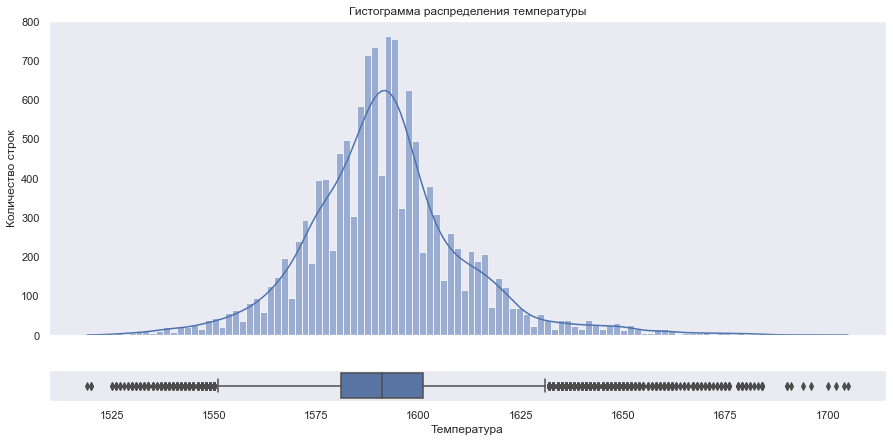

In [21]:
#строю гистограмму с температурой не ниже 1500
_, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[10,1]))

temp_hist = sns.histplot(data=data_temp[data_temp['Температура']>=1500], x='Температура', kde=True, ax=axs_hist)
temp_hist.set_ylabel('Количество строк')
temp_hist.set_title('Гистограмма распределения температуры')

temp_box = sns.boxplot(data=data_temp[data_temp['Температура']>=1500], x='Температура', ax=axs_box) 
temp_box.set_xlabel('Температура')

In [22]:
data_temp[data_temp['Температура']>=1500].describe()

,key,Температура
count,12999.000000,12999.000000
mean,1328.243942,1592.020078
std,804.821269,19.853665
min,1.000000,1519.000000
25%,638.000000,1581.000000
50%,1315.000000,1591.000000
75%,1977.500000,1601.000000
max,3241.000000,1705.000000


Без выбросов среднее - 1592, отклонение - 20

### 2.6. Данные о проволочных материалах / объем (data_wire)

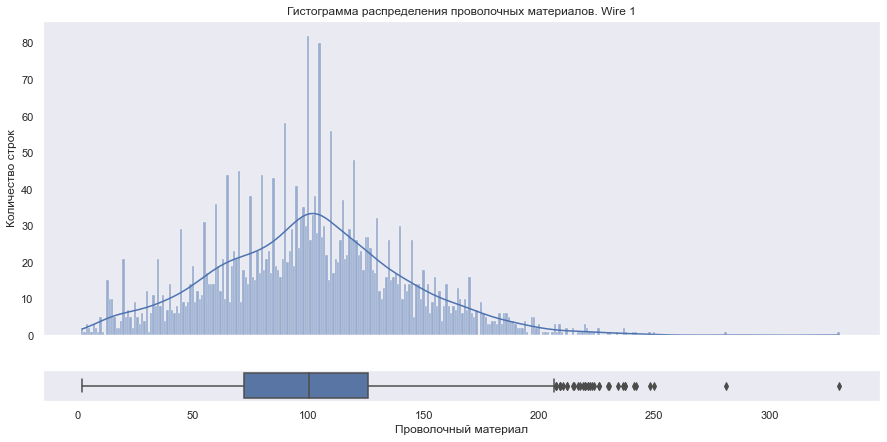

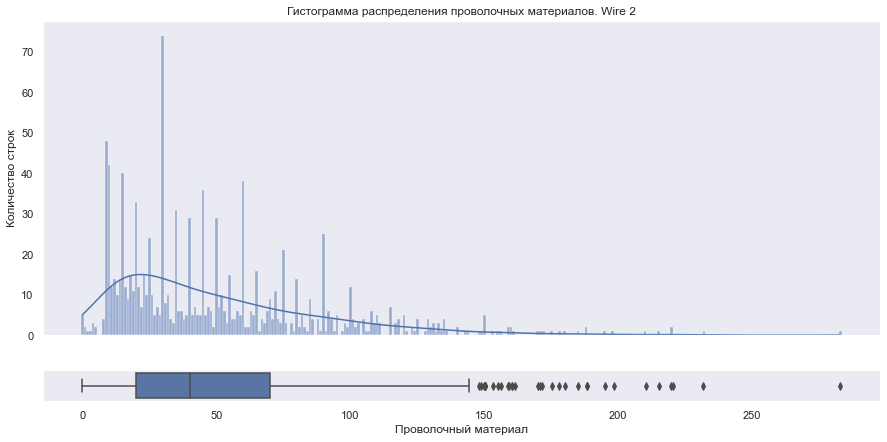

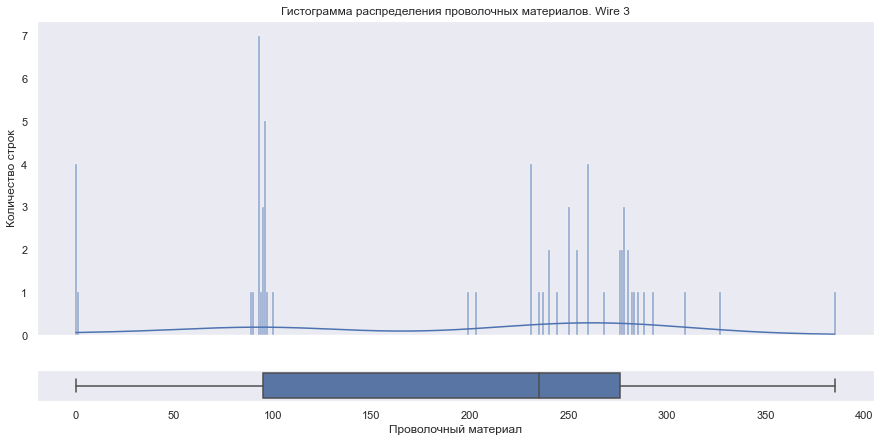

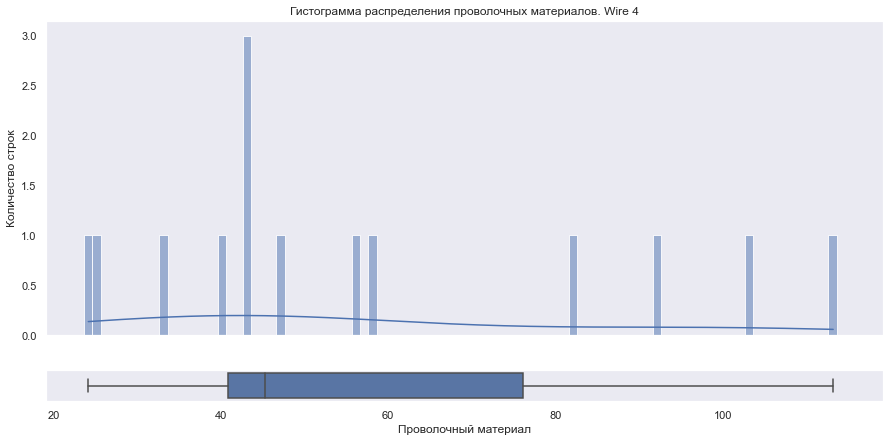

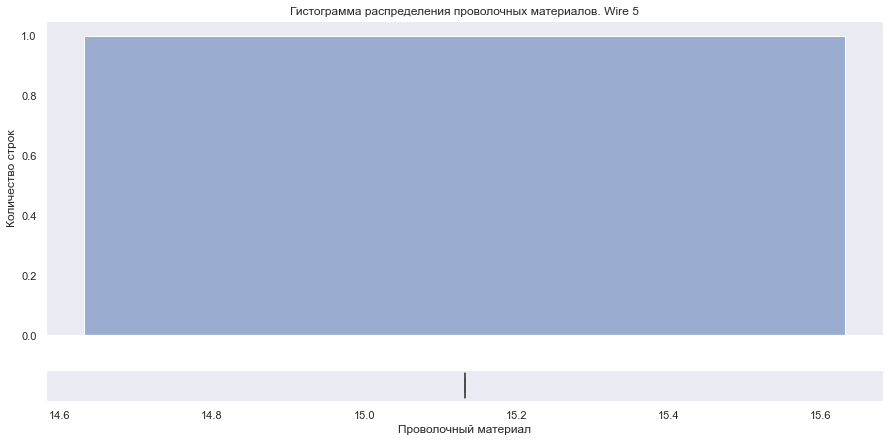

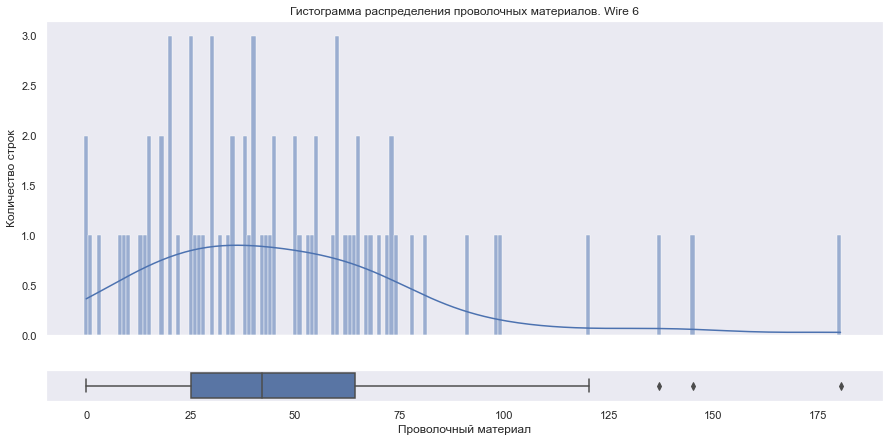

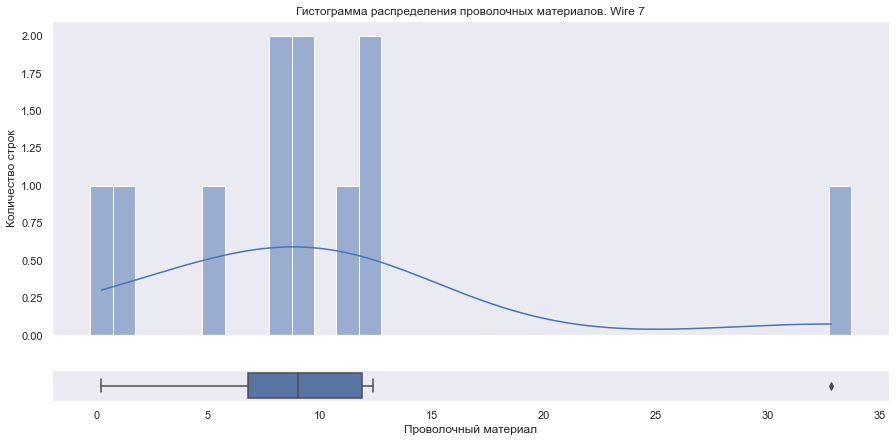

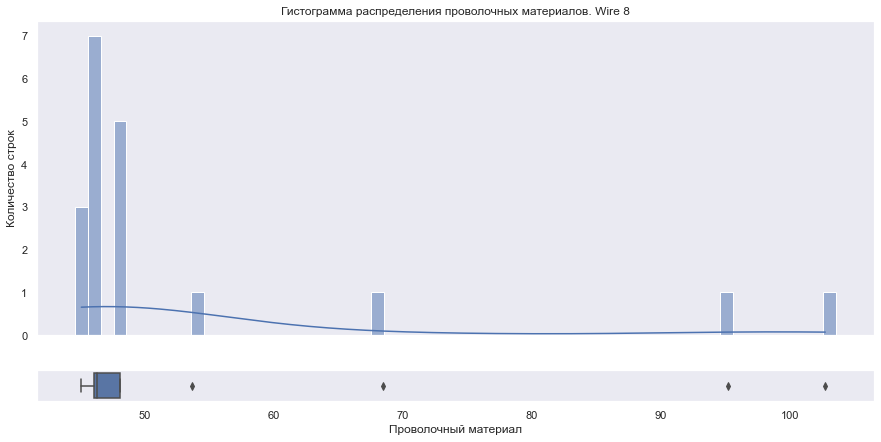

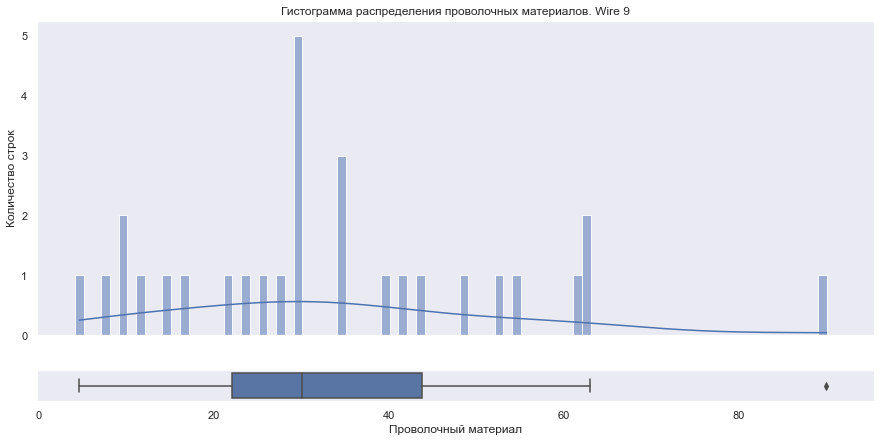

In [23]:
#строю гистограммы и боксплоты для признаков Wires

wires = data_wire.columns.to_list()[1:]

for wire in wires:
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[10,1]))

    wire_hist = sns.histplot(data=data_wire, x=wire, kde=True, discrete=True, ax=axs_hist)
    wire_hist.set_ylabel('Количество строк')
    wire_hist.set_title('Гистограмма распределения проволочных материалов. ' + wire)

    wire_box = sns.boxplot(data=data_wire, x=wire, ax=axs_box) 
    wire_box.set_xlabel('Проволочный материал')

Как и в случае с сыпучими материалами, видно, что разные виды проволоки добавляются в разных объемах, например, только 1 раз добавили `Wire 5`, меньше всего в среднем добавляют `Wire 7`, больше всего в среднем добавляют `Wire 3`.

На гистограммах `Wire 3`, `Wire 4`, `Wire 6`, `Wire 7`, `Wire 8`, `Wire 9` можно увидеть, что за 1 раз добавляется определенный объем проволоки.

Есть выбросы, но по объяснению заказчика, замеры отлаживались, поэтому это можно списать на погрешности

### 2.7. Данные о проволочных материалах / время (data_wire_time)

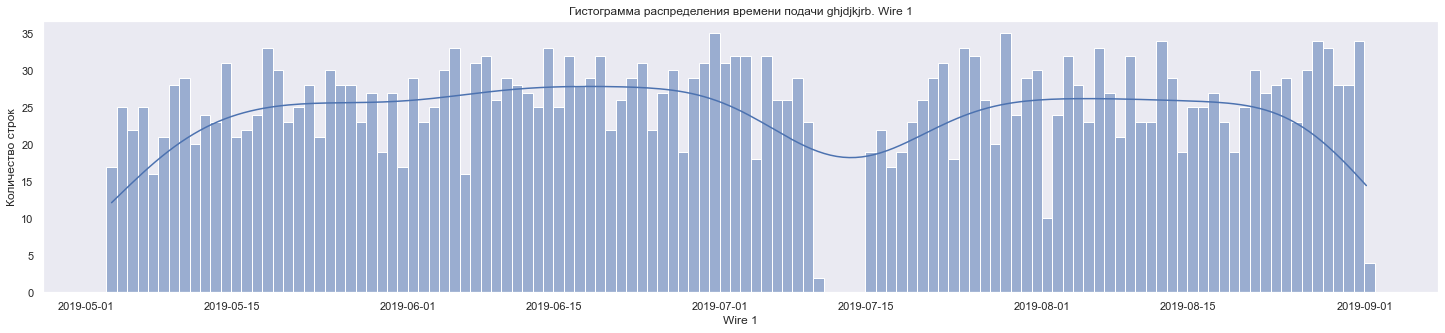

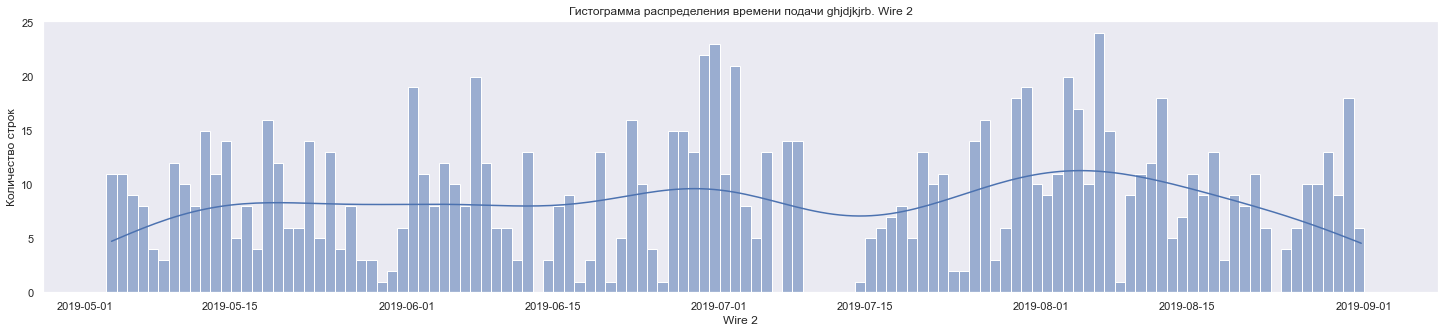

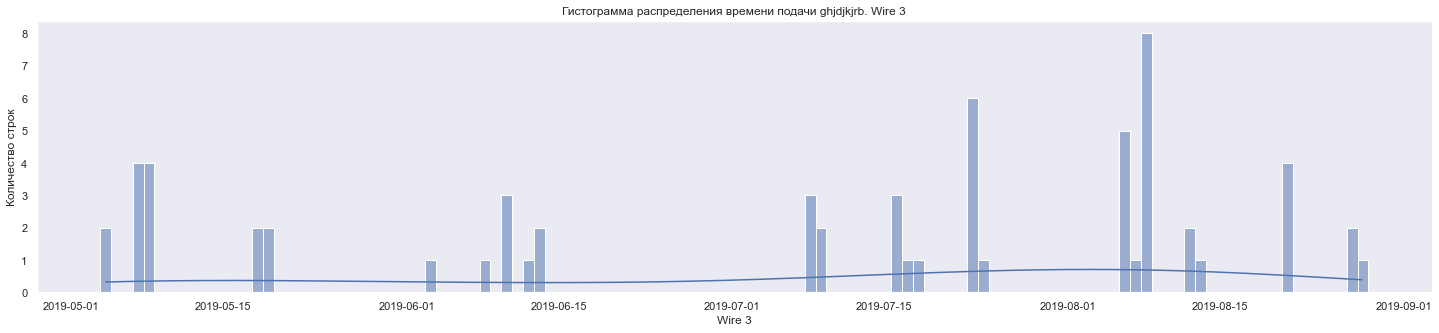

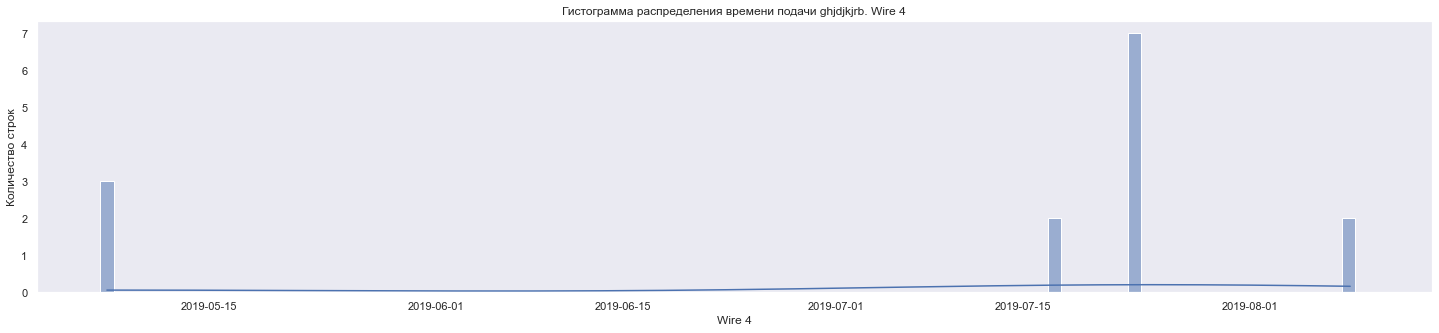

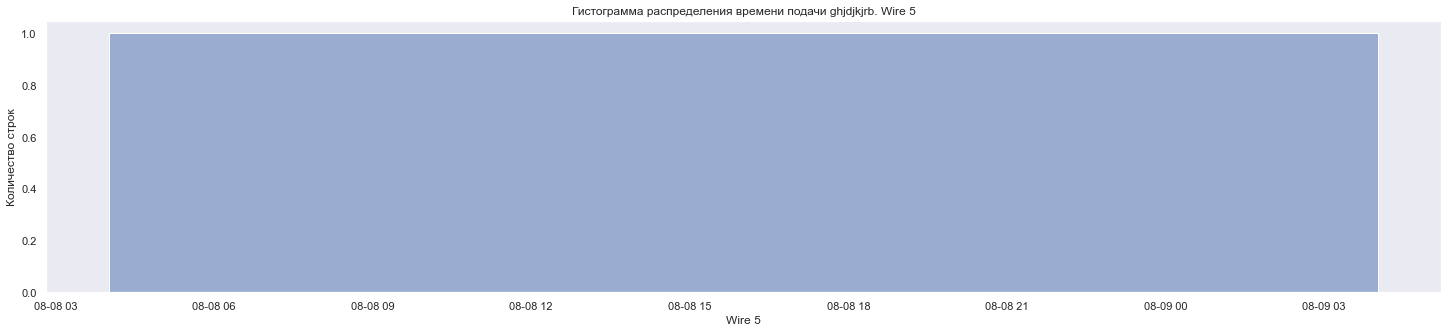

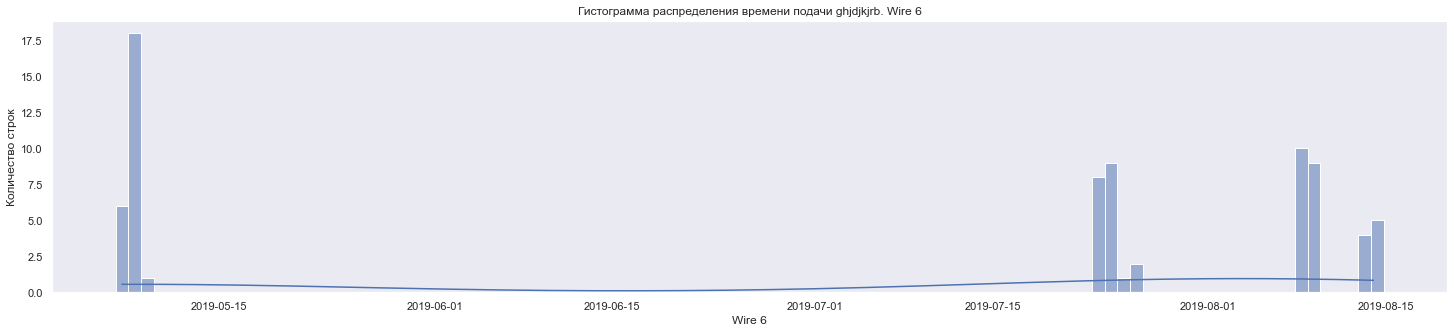

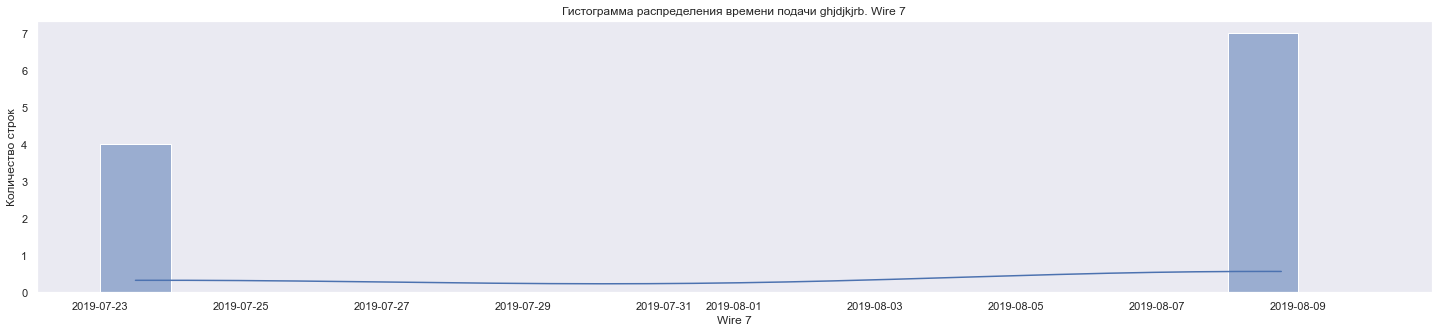

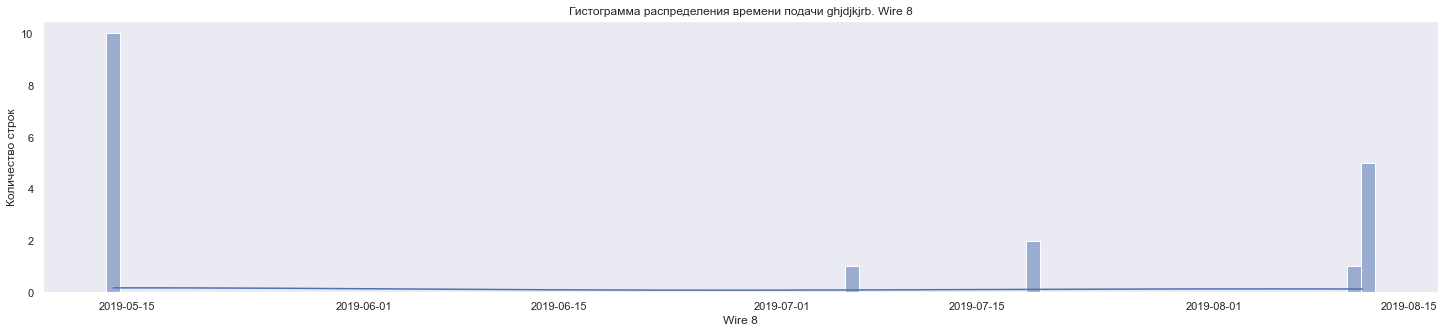

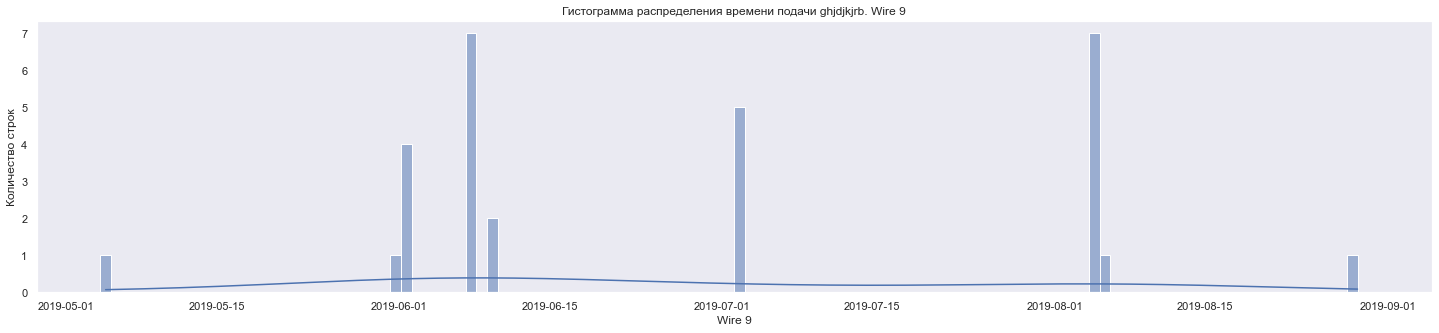

In [24]:
#строю гистограммы для признаков Wires
for wire in wires:
    sns.set(rc={"figure.figsize": (25, 5)})
    sns.set_style("dark")
    wire_hist = sns.histplot(data=data_wire_time, x=wire, kde=True, discrete=True)
    wire_hist.set_ylabel('Количество строк')
    wire_hist.set_title('Гистограмма распределения времени подачи ghjdjkjrb. ' + wire)
    plt.show()

По гистограммам видно, что есть пропуск 11-13 июля, аналогичный пропуску в data_arc, data_bulk_time, что логично.
В соответствие с датафреймом `data_wire`, на гистограммах видно, что разные проволоки добавляют с разной частотой.

### Выводы по п.2. EDA

1. В датафреймах data_bulk, data_bulk_time, data_wire, data_wire_time есть пропуски данных. Причина части пропусков известна от заказчика - сбор данных либо не был отлажен, либо в определенных партиях не подавались легирующие добавки. 
2. В всех признаках времени нет данных на 11-13 июля
3. В части признаков есть выбросы - отрицательная реактивная мощность, низкая температура. 
4. Во всех таблицах количество значений `key` разное, это надо будет учесть при объединении.
5. Также по условию надо удалить все промежуточные температуры.

## 3. Очистка данных. Заполнение данных

In [25]:
#удаляю все промежуточные температуры из датафрейма data_temp

def temp_start_finish(data):
    data_temp_sorted = pd.DataFrame()
    for key in data['key'].unique():
        sorted = data[data['key']==key].sort_values(by='Время замера')
        data_temp_sorted = data_temp_sorted.append(sorted.head(1))
        data_temp_sorted = data_temp_sorted.append(sorted.tail(1))
    return data_temp_sorted

data_temp = temp_start_finish(data_temp)

data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
10,2,2019-05-03 11:59:12,1602.0
11,3,2019-05-03 12:13:17,1596.0
...,...,...,...
15893,3239,2019-09-01 02:24:15,NaN
15894,3240,2019-09-01 02:39:01,1617.0
15901,3240,2019-09-01 03:35:16,NaN
15902,3241,2019-09-01 04:03:30,1586.0


In [26]:
#удаляю все строки с партиями, где нет данных по финишной температуре
key_NaN = data_temp[data_temp['Температура'].isna()]['key'].unique()
data_temp = data_temp[~data_temp['key'].isin(key_NaN)]
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
10,2,2019-05-03 11:59:12,1602.0
11,3,2019-05-03 12:13:17,1596.0
...,...,...,...
12258,2497,2019-08-06 01:53:50,1589.0
12259,2498,2019-08-06 02:03:49,1591.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0


In [27]:
#удаляю все строки с партиями, где температура <= 1500
key_1500 = data_temp[data_temp['Температура'] <= 1500]['key'].unique()
data_temp = data_temp[~data_temp['key'].isin(key_1500)]
data_temp = data_temp.reset_index(drop=True)
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:30:39,1613.0
2,2,2019-05-03 11:37:27,1581.0
3,2,2019-05-03 11:59:12,1602.0
4,3,2019-05-03 12:13:17,1596.0
...,...,...,...
4941,2497,2019-08-06 01:53:50,1589.0
4942,2498,2019-08-06 02:03:49,1591.0
4943,2498,2019-08-06 02:25:31,1594.0
4944,2499,2019-08-06 02:40:25,1569.0


In [28]:
#заполняю нулями пропуски в data_bulk и data_wire
data_bulk.fillna(0, inplace=True)
data_wire.fillna(0, inplace=True)

### Вывод по п.3. Очистка данных. Заполнение данных:
- удалила ранее отрицательную мощность, также удалила промежуточные температуры и температуру ниже 1500. Датафрейм `data_temp` сократился с 15907 до 4946 строк, то есть при разбиении таблицы на стартовую и финальную температуры одной партии должно получиться 2473 строки. 
- пропуски в data_bulk и data_wire заполнила нулями (в data_bulk_time и data_wire_time заменять не стала, так как эти датафреймы не понадобятся - нужные данные по времени есть в data_arc)

## 4. Построение единой таблицы

In [29]:
#вычисляю время между первым и последним замером температуры
#стартовая и финальная температуры - в отдельные столбцы-признаки

def delta_temp(data):
    list = []
    
    for key in data['key'].unique():
        tmp = data[data['key']==key].reset_index(drop=True)
        start = tmp.loc[0,'Температура']
        finish = tmp.loc[1,'Температура']
        delta = (tmp.loc[1,'Время замера'] - tmp.loc[0,'Время замера']).seconds

        list.append([key, start, finish, delta])
    
    return pd.DataFrame(list,
                        columns=['key',
                                 'Температура в начале',
                                 'Температура в конце. Целевой признак',
                                 'Время между замерами в сек'])

data_temp = delta_temp(data_temp)
data_temp

,key,Температура в начале,Температура в конце. Целевой признак,Время между замерами в сек
0,1,1571.0,1613.0,861
1,2,1581.0,1602.0,1305
2,3,1596.0,1599.0,1300
3,4,1601.0,1625.0,388
4,5,1576.0,1602.0,762
...,...,...,...,...
2468,2495,1570.0,1591.0,1137
2469,2496,1554.0,1591.0,1618
2470,2497,1571.0,1589.0,717
2471,2498,1591.0,1594.0,1302


In [30]:
#вычисляю время нагрева электродами по всем промежуткам для data_arc

data_arc['Время нагрева в сек'] = (data_arc['Конец нагрева дугой'] - 
                                   data_arc['Начало нагрева дугой']).dt.seconds
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева в сек
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148
...,...,...,...,...,...,...
14870,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157
14871,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180
14872,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184
14873,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57


In [31]:
#вычисляю затраты энергии для data_arc
data_arc['Энергия'] = data_arc['Время нагрева в сек'] * data_arc['Активная мощность']
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева в сек,Энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,222.541395
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,149.037310
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,128.030509
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,605.667332
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,102.527702
...,...,...,...,...,...,...,...
14870,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157,83.786125
14871,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180,121.788672
14872,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184,135.037503
14873,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57,12.579555


In [32]:
#поскольку прочие признаки были вычислительными для мощности, оставляю в data_arc только признак Энергия
data_arc = data_arc.groupby('key').agg({'Энергия': sum})
data_arc

,Энергия
key,
1,1207.804249
2,733.816470
3,443.583327
4,670.663327
5,997.496095
...,...
3237,777.993447
3238,432.849310
3239,844.977151


In [33]:
#объединяю датафреймы data_arc, data_temp, data_bulk, data_gas и data_wire
data = data_temp.merge(right=data_arc,
                       how='inner',
                       on='key')\
                .merge(right=data_bulk,
                       how='inner',
                       on='key')\
                .merge(right=data_gas,
                       how='inner',
                       on='key')\
                .merge(right=data_wire,
                       how='inner',
                       on='key')

data

,key,Температура в начале,Температура в конце. Целевой признак,Время между замерами в сек,Энергия,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,861,1207.804249,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1305,733.816470,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1300,443.583327,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,388,670.663327,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,762,997.496095,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,1137,626.167357,0.0,0.0,21.0,0.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2321,2496,1554.0,1591.0,1618,727.868032,0.0,0.0,0.0,63.0,0.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2322,2497,1571.0,1589.0,717,427.535518,0.0,0.0,0.0,85.0,0.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2323,2498,1591.0,1594.0,1302,629.928649,0.0,0.0,90.0,0.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#удаляю столбец 'Wire 5', так как он "пустой"
data.drop(['Wire 5'],inplace=True, axis=1)

Text(0.5, 1.0, 'Тепловая карта матрицы корреляций')

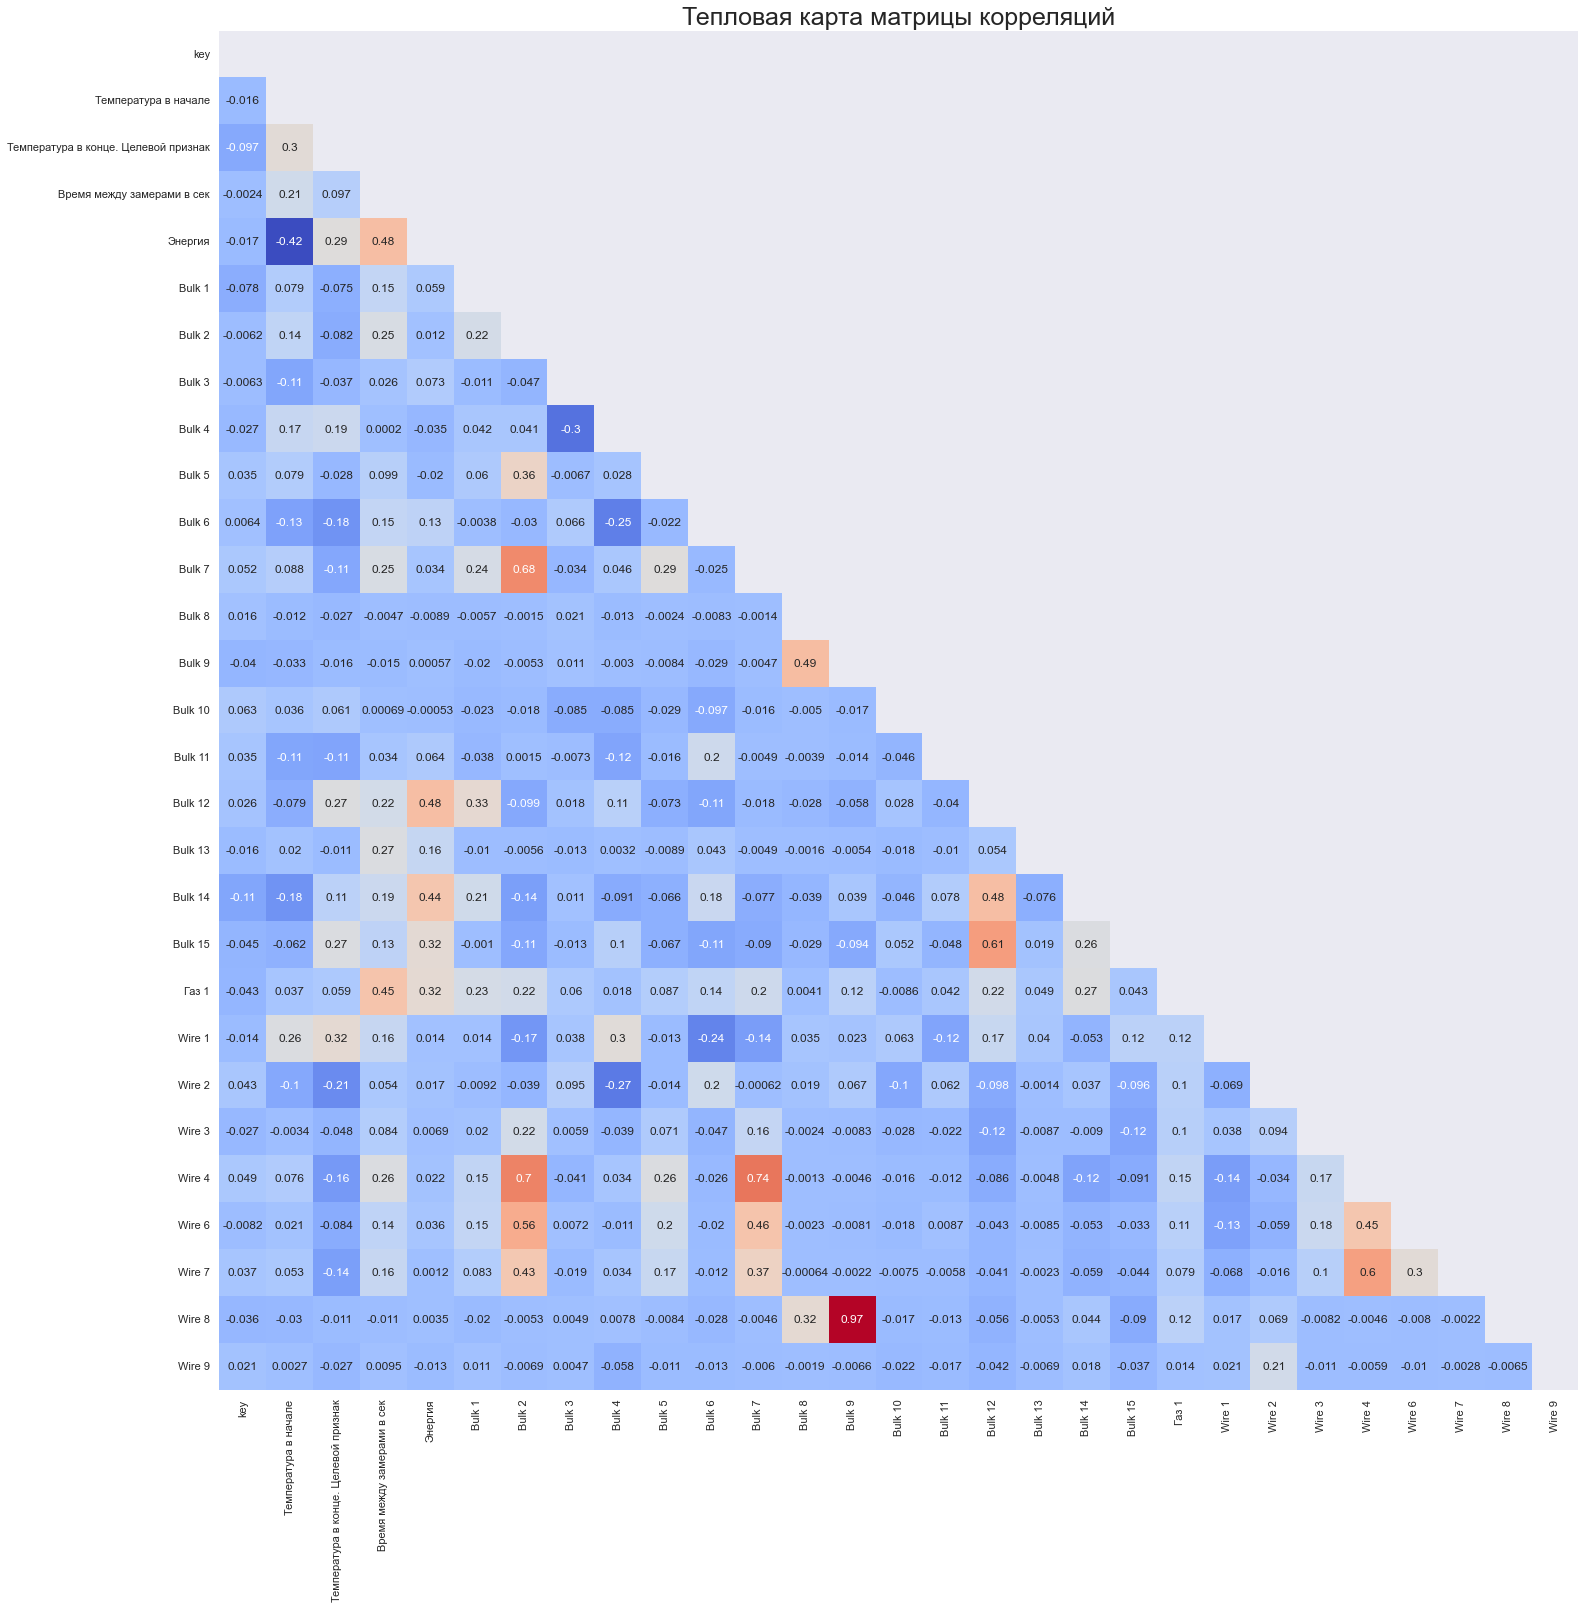

In [35]:
#строю тепловую карту корреляций
plt.figure(figsize=(25, 25))
matrix = np.triu(data.corr())
heatmap = sns.heatmap(data.corr(),
                      annot=True,
                      mask=matrix,
                      square=True,
                      cmap='coolwarm',
                      cbar=False,
                      fmt='.2g')
heatmap.set_title('Тепловая карта матрицы корреляций', fontsize=25)

In [36]:
data.corr()['Температура в конце. Целевой признак'].sort_values(ascending=False)[1:]

Wire 1                        0.317702
Температура в начале          0.301961
Энергия                       0.285554
Bulk 12                       0.267379
Bulk 15                       0.266386
Bulk 4                        0.188100
Bulk 14                       0.114520
Время между замерами в сек    0.097425
Bulk 10                       0.061345
Газ 1                         0.059036
Wire 8                       -0.010772
Bulk 13                      -0.010925
Bulk 9                       -0.016081
Bulk 8                       -0.026590
Wire 9                       -0.027496
Bulk 5                       -0.028365
Bulk 3                       -0.036767
Wire 3                       -0.047548
Bulk 1                       -0.075233
Bulk 2                       -0.082466
Wire 6                       -0.084049
key                          -0.097052
Bulk 7                       -0.107289
Bulk 11                      -0.114777
Wire 7                       -0.137275
Wire 4                   

Целевой признак сильнее коррелирует с:
- `Wire 1`
- `Температура в начале` (ожидаемо)
- `Энергия` (ожидаемо)
- `Bulk 12`
- `Bulk 15`
<br>прямо пропорционально, но даже с ними зависимость не слишком большая

Обратно пропорционально целевой признак связан сильнее всего с `Wire 2`, `Bulk 6`, `Wire 4`, но также не слишком сильно.

Интересно, что есть почти полная зависимость между `Wire 8` и `Bulk 9` и сильная между `Wire 4` и `Bulk 2` и `Bulk 7`.

### Выводы по п.4. Построение единой таблицы
- для выделения целевого признака выделила последний замер температуры в отдельный признак-столбец `Температура в конце. Целевой признак`, создала признак `Время между замерами`
- для вычисления признака `Энергия` (энергия, потраченной на нагревание), нашла разницу между `Начало нагрева дугой` и `Конец нагрева дугой` и умножила на `Активная мощность`
- объединила датафреймы по номеру партии `key`, причем только по тем номерам, которые есть во всех датафреймах, чтобы не было пропусков значений, удалила признаки, которые, на мой взгляд не влияют на целевой признак
- для выявления корреляций построила тепловую карту корреляций - сильных линейных корреляций с целевым признаком не выявила, однако есть сильная коррелация между признаками `Wire 8` и `Bulk 9`, поэтому для линейных регрессий один из призаков удалю

## 5. Разделение на выборки

In [37]:
features = data.drop(['Температура в конце. Целевой признак', 'key'], axis=1)
target = data['Температура в конце. Целевой признак']

In [38]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=.25,
                                                                            random_state=RANDOM_STATE)

In [39]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1743, 27), (582, 27), (1743,), (582,))

По условию задачи, выборки разделены в пропорции 3:1 с random_state 141122

## 6. Обучение моделей и выбор лучшей по показателю MAE

In [40]:
%%time

#обучаю линейную регрессию

features_train_lr = features_train.drop(['Wire 8'], axis=1) #удаляю сильнокоррелированный признак

lr = make_pipeline(StandardScaler(), LinearRegression())
lr_params = {'linearregression__normalize':[False]}
grid = GridSearchCV(lr, param_grid=lr_params, scoring='neg_mean_absolute_error')
grid.fit(features_train_lr, target_train)
predict = grid.predict(features_train_lr)

MAE_lr = mean_absolute_error(target_train, predict)

print('MAE для линейной регрессии -', MAE_lr)
print()

MAE для линейной регрессии - 5.942503448858672

CPU times: user 186 ms, sys: 75.6 ms, total: 262 ms
Wall time: 168 ms


In [41]:
%%time

#обучаю случайный лес

rfr = RandomForestRegressor() 

rfr_params = [{'criterion':['mae'],
               'n_estimators':[x for x in range(100, 501, 50)],
               'random_state':[RANDOM_STATE]}]

gscv = GridSearchCV(rfr, rfr_params, scoring='neg_mean_absolute_error', cv=5)

gscv.fit(features_train, target_train)

print('Параметры:', gscv.best_params_)
print()

MAE_rfr = max(gscv.cv_results_['mean_test_score']) * -1
print('MAE для случайного леса -', MAE_rfr)
print()

Параметры: {'criterion': 'mae', 'n_estimators': 200, 'random_state': 141122}

MAE для случайного леса - 6.14078238728057

CPU times: user 27min 10s, sys: 6.5 s, total: 27min 16s
Wall time: 27min 18s


In [42]:
%%time

#обучаю CatBoostRegressor

cbr = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)

MAE_cbr = (cross_val_score(cbr,
                           features_train, 
                           target_train, 
                           cv=5, 
                           scoring='neg_mean_absolute_error').mean() * -1)

params_cbr = CatBoostRegressor(verbose=False,
                               random_state=RANDOM_STATE).\
                               fit(features_train, target_train).\
                               get_all_params()

print('Параметры:', params_cbr)
print()

print('MAE для CatBoostRegressor -', MAE_cbr)
print()

Параметры: {'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 141122, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.04470000043511391, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_est

In [44]:
%%time

#обучаю LGBMRegressor

lgbm = LGBMRegressor() 
lgbm_params = [{'num_leaves':[x for x in range(10,26)], 
                'learning_rate':[.1],
                'random_state':[RANDOM_STATE]}]

gscv = GridSearchCV(lgbm, lgbm_params, scoring='neg_mean_absolute_error', cv=5)

gscv.fit(features_train, target_train)

print('Параметры:', gscv.best_params_)
print()

MAE_lgbm = (max(gscv.cv_results_['mean_test_score'])*-1)
print('MAE для LGBMRegressor -', MAE_lgbm)
print()

Параметры: {'learning_rate': 0.1, 'num_leaves': 12, 'random_state': 141122}

MAE для LGBMRegressor - 5.947636289657943

CPU times: user 33.6 s, sys: 3.27 s, total: 36.9 s
Wall time: 4.94 s


In [45]:
%%time

#обучаю XGBRegressor

xgbr = XGBRegressor() 
xgbr_params = [{'learning_rate':[x/100 for x in range(1, 51)],
                'random_state':[RANDOM_STATE]}]

gscv = GridSearchCV(xgbr, xgbr_params, scoring='neg_mean_absolute_error', cv=5)
gscv.fit(features_train, target_train)

print('Параметры:', gscv.best_params_)
print()

MAE_xgbr = (max(gscv.cv_results_['mean_test_score'])*-1)
print('MAE для XGBRegressor -', MAE_xgbr)
print()

Параметры: {'learning_rate': 0.09, 'random_state': 141122}

MAE для XGBRegressor - 5.950063788703561

CPU times: user 3min 53s, sys: 33.2 s, total: 4min 26s
Wall time: 35.7 s


In [46]:
%%time

#обучаю полиномиальную регрессию

model = make_pipeline(PolynomialFeatures(), LinearRegression())
model_params = {'linearregression__normalize':[False]}
grid = GridSearchCV(model, param_grid=model_params, scoring='neg_mean_absolute_error')
grid.fit(features_train_lr, target_train)
predict = grid.predict(features_train_lr)

MAE_poly = mean_absolute_error(target_train, predict)
print('MAE для полиномиальной регрессии -', MAE_poly)
print()

MAE для полиномиальной регрессии - 4.9369750586782555

CPU times: user 2.06 s, sys: 772 ms, total: 2.83 s
Wall time: 415 ms


In [48]:
#собираю все MAE в таблицу

index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'XGBRegressor',
         'Polynomial regression']

data = {'MAE на обучающей выборке': [MAE_lr,
                                     MAE_rfr,
                                     MAE_cbr,
                                     MAE_lgbm,
                                     MAE_xgbr,
                                     MAE_poly]}

kpi = pd.DataFrame(data=data, index=index)

kpi.sort_values(by='MAE на обучающей выборке', ascending=False)

,MAE на обучающей выборке
RandomForestRegressor,6.140782
XGBRegressor,5.950064
LGBMRegressor,5.947636
LinearRegression,5.942503
CatBoostRegressor,5.905396
Polynomial regression,4.936975


### Вывод по п.6. Обучение моделей 
Наилучший результат дала полиномиальная регрессия - MAE = 4.9. Проведу тестирование полиномиальной регрессии 

## 7. Предсказание на тестовой выборке

In [49]:
model = make_pipeline(PolynomialFeatures(), LinearRegression())
model_params = {'linearregression__normalize':[False]}
grid = GridSearchCV(model, param_grid=model_params, scoring='neg_mean_absolute_error')
grid.fit(features_test, target_test)
predict = grid.predict(features_test)

MAE_poly = mean_absolute_error(target_test, predict)
print('MAE для полиномиальной регрессии -', MAE_poly)
print()

MAE для полиномиальной регрессии - 4.400271009490424



### Вывод по п.7. Предсказание на тестовой выборке
MAE на тестовой выборке полиномиальной регрессии - 4.4

## 8. Проверка модели на вменяемость 

In [50]:
for strategy in ['mean', 'median']:
    dummy = DummyRegressor(strategy=strategy)
    dummy.fit(features_train_lr, target_train)   
    predict = dummy.predict(features_test)   
    MAE_dummy = mean_absolute_error(target_test, predict)   
    print('Для стратегии', strategy, 'MAE -', MAE_dummy)

Для стратегии mean MAE - 7.830899444612022
Для стратегии median MAE - 7.790378006872852


Значения MAE, показанные DummyRegressor, оказались выше, чем у полиномиальной регрессии. Поэтому буду считать, что модель прошла проверку на вменяемость

## 9. Анализ значимости признаков для предсказания

In [51]:
model = make_pipeline(PolynomialFeatures(), LinearRegression())
model.fit(features_train_lr, target_train)

feature_names = model[:-1].get_feature_names_out()
feature_coefficients = model.steps[1][1].coef_

zipped = zip(feature_names, feature_coefficients)
coefs = pd.DataFrame(zipped, columns=['Признаки', 'Коэффициенты'])
coefs['Абсолютное значение'] = coefs['Коэффициенты'].apply(lambda x: abs(x))
coefs['Маркер'] = coefs['Коэффициенты'].apply(lambda x: 'green' if x > 0 else 'red')
coefs = coefs.sort_values('Абсолютное значение', ascending=False)

coefs

,Признаки,Коэффициенты,Абсолютное значение,Маркер
26,Wire 9,6.053691,6.053691,green
19,Газ 1,4.591880,4.591880,green
8,Bulk 5,-4.345487,4.345487,red
22,Wire 3,1.727019,1.727019,green
4,Bulk 1,1.625582,1.625582,green
...,...,...,...,...
340,Bulk 15 Wire 7,0.000000,0.000000,red
259,Bulk 9 Bulk 10,0.000000,0.000000,red
257,Bulk 8 Wire 9,0.000000,0.000000,red
255,Bulk 8 Wire 6,0.000000,0.000000,red


Text(0.5, 0, 'Признаки')

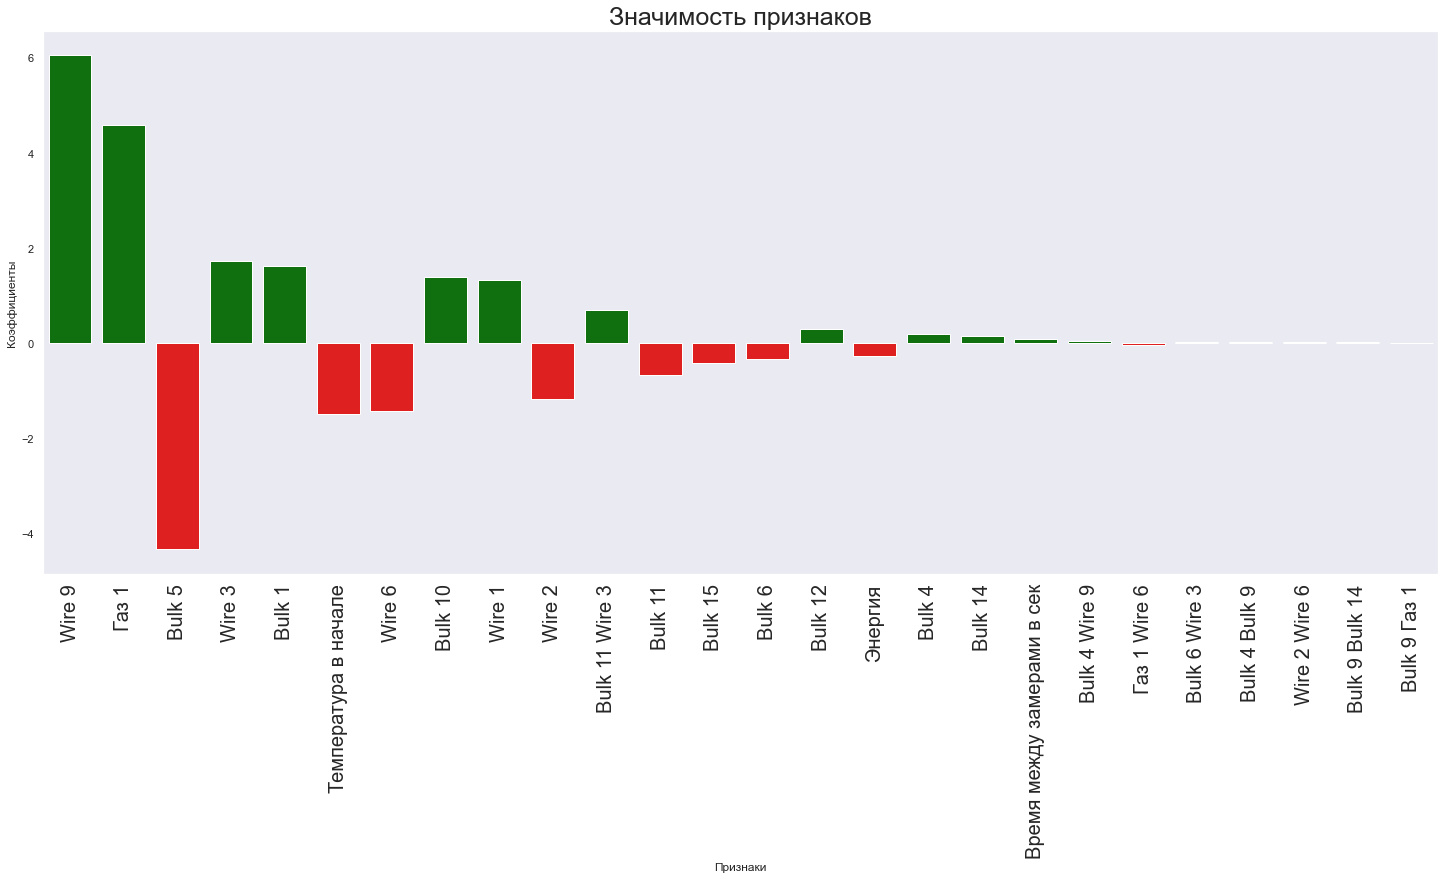

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.barplot(x='Признаки',
            y='Коэффициенты',
            data=coefs.head(26),
            palette=coefs.head(26)['Маркер']) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title('Значимость признаков', fontsize=25)
ax.set_ylabel('Коэффициенты')
ax.set_xlabel('Признаки')

### Вывод по п.9 Значимость признаков для предсказания

Из полученного графика видно, что на финальную температуру в большей степени влияют:
- `Wire 9`
- `Газ 1`
- `Bulk 5`
- `Wire 3`
- `Bulk 1`

При этом коэффициенты `Wire 9`, `Газ 1`, `Wire 3` и `Bulk 1` - положительные, то есть эти легирующие добавки оказывают положительную взаимосвязь на финальную температуру, другими словами, они ее как минимум не снижают, то есть при подаче этих легирующих материалов температура не падает, следовательно, не требуется дополнительная энергия на нагрев.
А у `Bulk 5` коэффициент отрицательный, следовательно, между `Bulk 5` и финальной температурой - негативная связь (другими словами, при подаче `Bulk 5` характерно остывание)

## 10. Общий вывод

Для оптимизации расходов комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Надо было построить модель, которая предскажет температуру сплава.

Для решения этой задачи проделано следующее:
1. В результате EDA были выявлены:
- пропуски, в том числе 11-3 июля из-за остановки производства
- выбросы 
- разное кол-во и значения партий (`key`)

2. При подготовке данных выбросы были удалены, пропуски частично заполнены нулями в том случае, если легирующие добавки не подавались. 
<br>Были выведены дополнительные признаки  - время между замерами температуры и энергию, потраченную на нагрев. Полученные таблицы были объединены по номеру партии `key` (по тем номерам партий, которые были во всех таблицах).
<br>Также была изучена корреляция признаков, в результате были выявлены сильная корреляция между двумя признаками (легириующими добавками), но не выявлено сильной зависимости каких-либо признаков с целевым - финальной температурой на этапе.

3. Для предсказаний выбрала модели:
    - LinearRegression
    - RandomForestRegressor
    - CatBoostRegressor
    - LGBMRegressor
    - XGBRegressor
    - Polynomial regression 
<br>с масштабированием и кросс-валидацией.

4. Наилучший результат MAE дала полиномиальная модель, которая на обучающей выборке без сильнокореллирующих признаков дала MAE = 4.9, на тестовой выборке дала MAE = 4.4. При этом на целевой признак более всего влияют признаки Wire 9, Газ 1, Bulk 5, Wire 3, Bulk 1.
<br>Проверку на вменяемость модель прошла. 

<br>Таким образом, для предсказания температуры сплава (а следовательно, потерь электроэнергии) подойдет полиномиальная регрессия, которая ошибается на 4.4 градуса

# Отчет

**1. Выполнение плана**
<br>В плане было:
   1. Загрузка и обзор данных
   2. EDA
   3. Очистка данных. Заполнение данных
   4. Построение единой таблицы
   5. Разделение на выборки 3:1
   6. Обучение моделей с кросс-валидацией и выбор лучшей по показателю MAE
   7. Предсказание на тестовой выборке
   8. Анализ значимости признаков для предсказания
   9. Общий вывод
   
<br>Все пункты плана были выполнены, в изначательный план был добавлен п.8. Анализ значимости признаков для предсказания

**2. Трудности и решения**
<br>На этапе EDA были обнаружены пропуски данных, связанные с:
   - неотлаженным сбором данных, что было просто принято
   - неподачей легирующих добавок, что было решено заменой на 0 (нет добавки = 0)
   - остановкой варок 11-13 июля, что также было просто принято
      
<br>а также отрицательная реактивная мощность, температура ниже 1500, что было исключено из анализа, как ошибка.
<br>Кроме того, во всех датафреймах количество и перечень номеров партий (признак-столбец `key`) было разное, поэтому при объединении таблиц для анализа былии взяты только те партии, данные по которым были во всех датафреймах, чтобы анализ был точнее.
   
**3. Ключевые шаги в решении задачи**
<br>Ключевыми шагами в решении задачи стали блоки:
   - EDA и последующая очистка и заполнение данных, что обеспечило более качественный анализ и лучшую работу моделей
   - обучение моделей со сменой параметров и выбор лучшей по показателю MAE (Mean absolute error - средняя абсолютная ошибка, то есть показатель того, насколько градусов модель ошибается при расчете, соотвественно, чем меньше ошибка, тем лучше работает модель). Для поиска наилучшего показателя MAE были обучены 6 моделей, протестирована модель с наименьшей MAE

**4. Итоговая модель и её качество**
<br>Итоговой моделью была выбрана полиномиальная регрессия - модель с наименьшей MAE среди обученных. MAE полиномиальной регрессии = 4.4, это означает, что модель ошибается на 4.4 градуса при прогнозировании.
<br>При этом легирующие добавки `Wire 9`, `Газ 1`, `Wire 3` и `Bulk 1`, как минимум, не снижают температуру, то есть при подаче этих легирующих материалов температура не падает, следовательно, не требуется дополнительная энергия на нагрев. А при подаче `Bulk 5` характерно остывание. Таким образом, при планировании варок необходимо учитывать эти моменты